In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [2]:
from IPython.display import display
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import SelectKBest

In [3]:
from dython.nominal import associations

In [4]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head().T

(1460, 81)


0       1       2        3       4
Id                  1       2       3        4       5
MSSubClass         60      20      60       70      60
MSZoning           RL      RL      RL       RL      RL
LotFrontage      65.0    80.0    68.0     60.0    84.0
LotArea          8450    9600   11250     9550   14260
...               ...     ...     ...      ...     ...
MoSold              2       5       9        2      12
YrSold           2008    2007    2008     2006    2008
SaleType           WD      WD      WD       WD      WD
SaleCondition  Normal  Normal  Normal  Abnorml  Normal
SalePrice      208500  181500  223500   140000  250000

[81 rows x 5 columns]

In [5]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head().T

(1459, 80)


0       1       2       3       4
Id               1461    1462    1463    1464    1465
MSSubClass         20      20      60      60     120
MSZoning           RH      RL      RL      RL      RL
LotFrontage      80.0    81.0    74.0    78.0    43.0
LotArea         11622   14267   13830    9978    5005
...               ...     ...     ...     ...     ...
MiscVal             0   12500       0       0       0
MoSold              6       6       3       6       1
YrSold           2010    2010    2010    2010    2010
SaleType           WD      WD      WD      WD      WD
SaleCondition  Normal  Normal  Normal  Normal  Normal

[80 rows x 5 columns]

### FROM EDA

In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
cats_train = train.select_dtypes(include='object').columns
cats_test = test.select_dtypes(include='object').columns
print('No of train cat_cols : ',len(cats_train))
print('No of test cat_cols : ',len(cats_test))

No of train cat_cols :  43
No of test cat_cols :  43


In [7]:
nums_train = train.select_dtypes(exclude='object').columns
nums_test = test.select_dtypes(exclude='object').columns
print('No of train cat_cols : ',len(nums_train))
print('No of test cat_cols : ',len(nums_test))

No of train cat_cols :  38
No of test cat_cols :  37


In [107]:
def plot_corr_mi_median_one_feature(df,targets,cols,target_col,active_col,fill_na='missing'):
    df_def =df.copy()
    df_def[target_col]=targets
    df_def = df_def.fillna(fill_na)
    cols=cols.copy()
    cols.extend(active_col)
    def mutual_info_price_score(series):
        return mutual_info_score(series,df_def[target_col])
    
    mi_normal = df_def[cols].apply(mutual_info_price_score)
    features = mi_normal.sort_values(ascending=False).index.to_list()
    scores = mi_normal.sort_values(ascending=False).values
    
    corr_cat = associations(dataset=df_def[(cols +[target_col])],numerical_columns=target_col,nan_replace_value=fill_na,cmap='viridis',mark_columns=False,ax=None,compute_only=True)
    #corr_num_cat['corr']['SalePrice']['MSSubClass']
    #correlation = df_def[cols].corrwith(df_def[target_col])
    mi_corr_df = pd.DataFrame(scores,index=features,columns=['mi_score'])
    mi_corr_df['Corr_Score']= [corr_cat['corr'][target_col][col]  for col in features ]
    
    display(mi_corr_df)
    
    print()
    plt.rc("figure",figsize=(12,6))
    X_axis = np.arange(0,mi_corr_df.shape[0])
    max_mi_score = mi_corr_df['mi_score'].max() # since correlation is always <=1 ..for better visualization we normalize
    min_mi_score = mi_corr_df['mi_score'].min()
    norm_mi_score = (mi_corr_df['mi_score'] - min_mi_score)/(max_mi_score-min_mi_score)
    plt.bar(X_axis,norm_mi_score,label='Mi_score',width=0.3)
    plt.bar(X_axis + 0.3,mi_corr_df['Corr_Score'],label='Corr_Score',width=0.25)
    ticks = X_axis # points on the x axis where you want the label to appear
    labels=mi_corr_df.index
    plt.xticks(ticks, labels);
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title("Mi Score and Correlation Score")
    plt.legend()
    plt.show()
    
    sort_target = df_def.groupby(active_col)[target_col].median().sort_values(ascending=False).index
    sns.boxplot(y=target_col, x=active_col, data= df_def, order= sort_target)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title('BoxPlot of new_feature');
    plt.show()
    print()

    
    #return mi_corr_df
    


In [8]:
base_cat=['Neighborhood', 'Exterior2nd', 'Exterior1st', 'BsmtFinType1',
       'FireplaceQu', 'GarageFinish', 'BsmtQual', 'KitchenQual', 'GarageType',
       'BsmtExposure', 'Foundation', 'HeatingQC', 'ExterQual', 'MasVnrType',
       'SaleCondition', 'MSZoning', 'SaleType']

{'RL': 'Residential Low Density',
 'RM': 'Residential Medium Density',
 'FV': 'Floating Village Residential',
 'RH': 'other',
 'C (all)': 'other'}

mi_score  Corr_Score
Neighborhood     2.003888    0.738630
Exterior2nd      1.172542    0.392211
Exterior1st      1.116941    0.390862
BsmtFinType1     0.961786    0.459141
FireplaceQu      0.752668    0.542181
GarageFinish     0.752268    0.553059
BsmtQual         0.747080    0.681905
KitchenQual      0.676428    0.675721
GarageType       0.673624    0.499204
BsmtExposure     0.666649    0.386653
Foundation       0.637097    0.506328
HeatingQC        0.603568    0.442154
ExterQual        0.602146    0.690933
MasVnrType       0.558353    0.434537
SaleCondition    0.466175    0.368100
MSZoning         0.423127    0.327963
median_MSZoning  0.411261    0.324632
SaleType         0.403521    0.370523

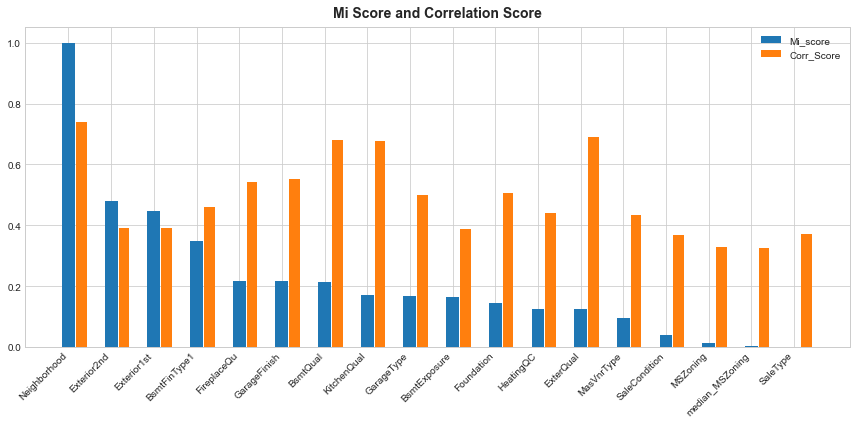

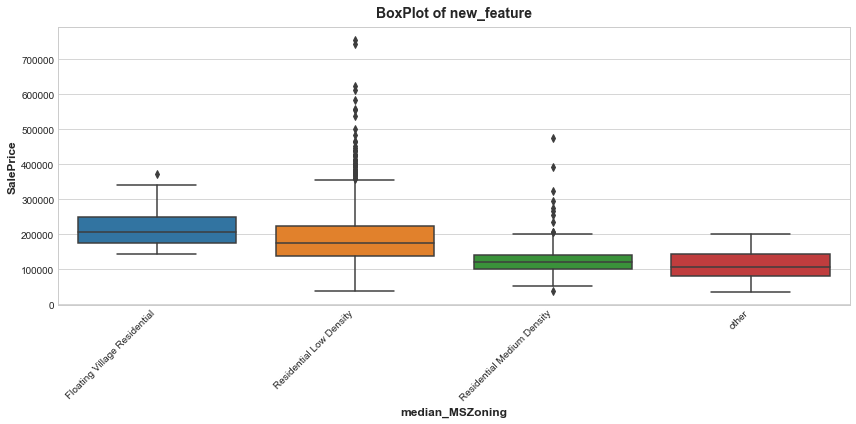

In [26]:
rank_MSZoning=['Residential Low Density','Residential Medium Density','Floating Village Residential','other','other']
plot_corr_mi_median_one_feature(df=train,cols=base_cat,target_col='SalePrice',active_col='MSZoning',fill_na='missing',rank=rank_MSZoning)

{'Reg': 'Regular', 'IR1': 'Irregular', 'IR2': 'Irregular', 'IR3': 'Irregular'}

mi_score  Corr_Score
Neighborhood     2.003888    0.738630
Exterior2nd      1.172542    0.392211
Exterior1st      1.116941    0.390862
BsmtFinType1     0.961786    0.459141
FireplaceQu      0.752668    0.542181
GarageFinish     0.752268    0.553059
BsmtQual         0.747080    0.681905
KitchenQual      0.676428    0.675721
GarageType       0.673624    0.499204
BsmtExposure     0.666649    0.386653
Foundation       0.637097    0.506328
HeatingQC        0.603568    0.442154
ExterQual        0.602146    0.690933
MasVnrType       0.558353    0.434537
SaleCondition    0.466175    0.368100
MSZoning         0.423127    0.327963
SaleType         0.403521    0.370523
median_LotShape  0.348831    0.267672

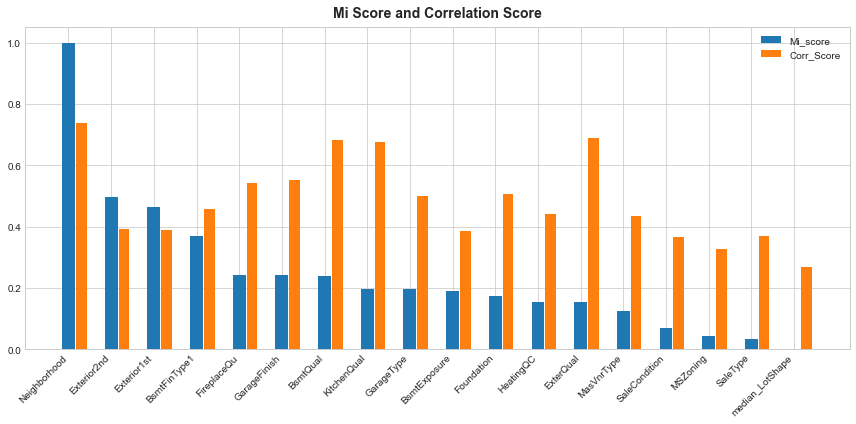

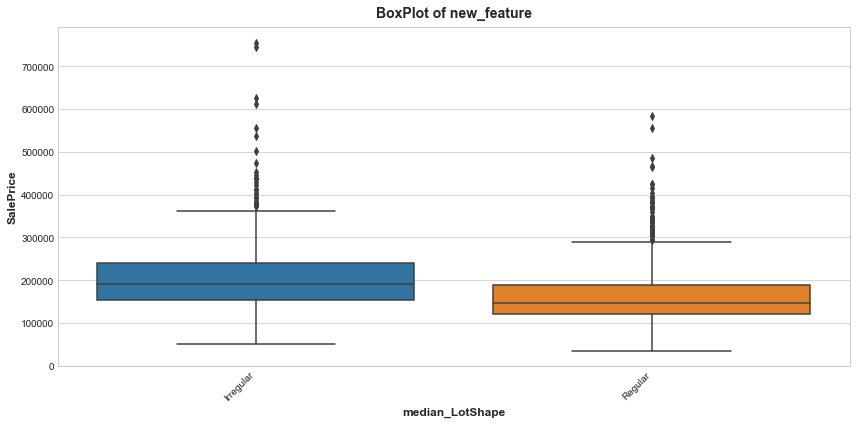

In [28]:
rank_LotShape=['Regular','Irregular','Irregular','Irregular']
plot_corr_mi_median_one_feature(df=train,cols=base_cat,target_col='SalePrice',active_col='LotShape',fill_na='missing',rank=rank_LotShape)

{'Lvl': 'Level', 'Bnk': 'Not_level', 'HLS': 'Not_level', 'Low': 'Not_level'}

mi_score  Corr_Score
Neighborhood        2.003888    0.738630
Exterior2nd         1.172542    0.392211
Exterior1st         1.116941    0.390862
BsmtFinType1        0.961786    0.459141
FireplaceQu         0.752668    0.542181
GarageFinish        0.752268    0.553059
BsmtQual            0.747080    0.681905
KitchenQual         0.676428    0.675721
GarageType          0.673624    0.499204
BsmtExposure        0.666649    0.386653
Foundation          0.637097    0.506328
HeatingQC           0.603568    0.442154
ExterQual           0.602146    0.690933
MasVnrType          0.558353    0.434537
SaleCondition       0.466175    0.368100
MSZoning            0.423127    0.327963
SaleType            0.403521    0.370523
median_LandContour  0.179473    0.027545

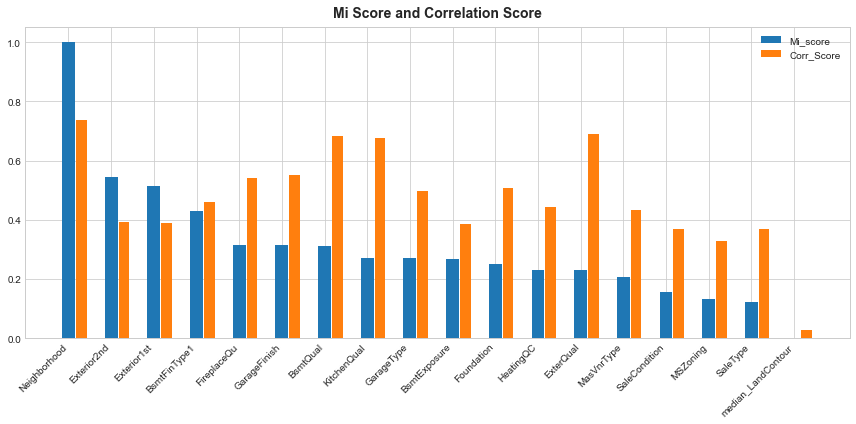

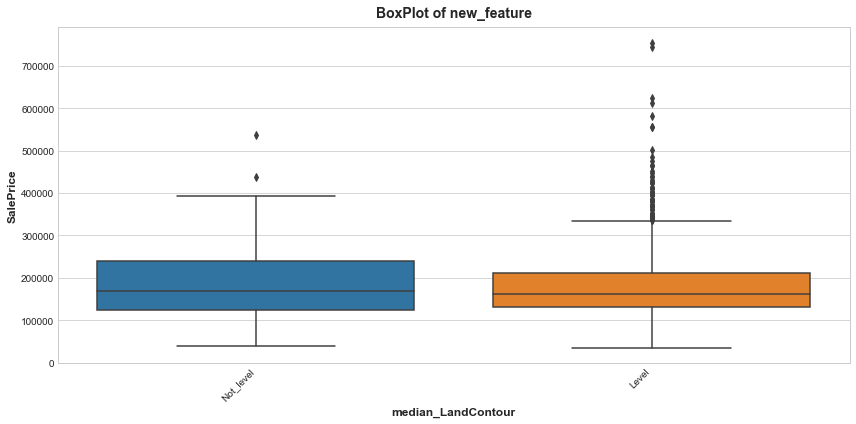

In [30]:
rank_LandContour=['Level','Not_level','Not_level','Not_level']
plot_corr_mi_median_one_feature(df=train,cols=base_cat,target_col='SalePrice',active_col='LandContour',fill_na='missing',rank=rank_LandContour)

{'Gtl': 'Level', 'Mod': 'Not_level', 'Sev': 'Not_level'}

mi_score  Corr_Score
Neighborhood      2.003888    0.738630
Exterior2nd       1.172542    0.392211
Exterior1st       1.116941    0.390862
BsmtFinType1      0.961786    0.459141
FireplaceQu       0.752668    0.542181
GarageFinish      0.752268    0.553059
BsmtQual          0.747080    0.681905
KitchenQual       0.676428    0.675721
GarageType        0.673624    0.499204
BsmtExposure      0.666649    0.386653
Foundation        0.637097    0.506328
HeatingQC         0.603568    0.442154
ExterQual         0.602146    0.690933
MasVnrType        0.558353    0.434537
SaleCondition     0.466175    0.368100
MSZoning          0.423127    0.327963
SaleType          0.403521    0.370523
median_LandSlope  0.128400    0.051116

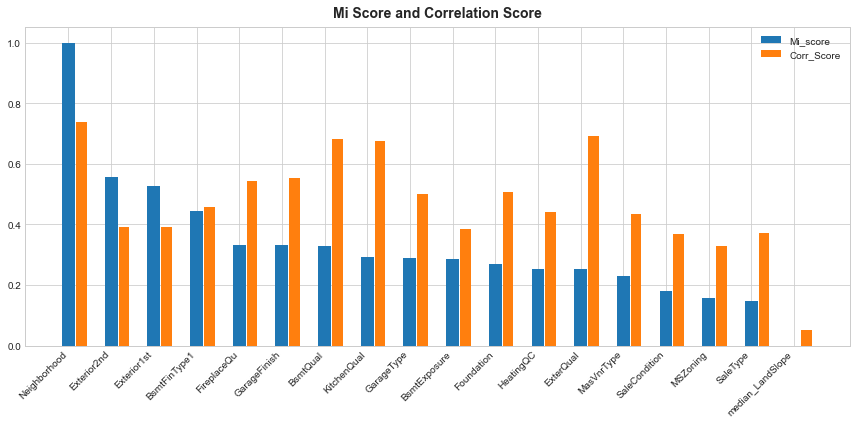

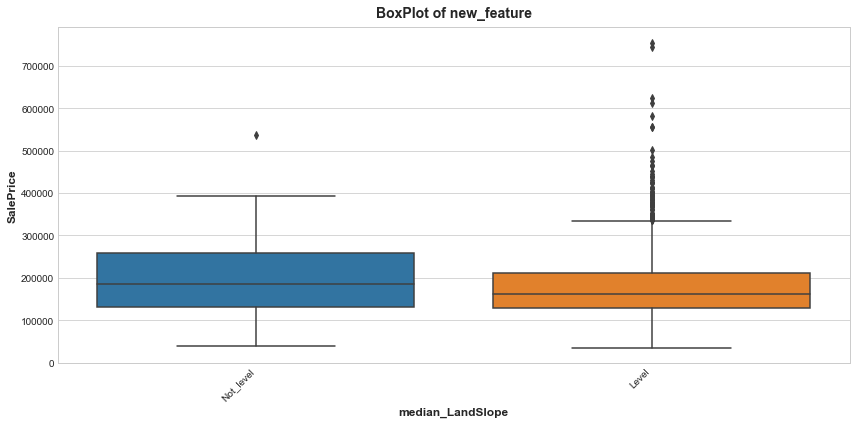

In [32]:
rank_LandSlope=['Level','Not_level','Not_level']
plot_corr_mi_median_one_feature(rank=rank_LandSlope,df=train,cols=base_cat,target_col='SalePrice',active_col='LandSlope',fill_na='missing')

In [ ]:
for v in [2, 3, 4]:
        for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

In [12]:
rank=['Residential Low Density','Residential Medium Density','Floating Village Residential','other','other']
MSZoning_dict ={}
for i,j in zip(train.MSZoning.value_counts().index,rank):
    MSZoning_dict[i]=j
MSZoning_dict

{'RL': 'Residential Low Density',
 'RM': 'Residential Medium Density',
 'FV': 'Floating Village Residential',
 'RH': 'other',
 'C (all)': 'other'}

In [ ]:
def Similar_Category(df,column,similar_categories,category):   
    rows_with_matches = df[column].isin(similar_categories)
    df.loc[rows_with_matches,column] = category
    return df

In [102]:
'finished' in 'One and one-half story: 2nd level finished'

True

In [103]:
'Two and one-half'in'Two and one-half story: 2nd level finished'

True

In [105]:
'Two and one-half'in'Two and one-half story: 2nd level unfinished'

True

In [9]:
def prepare_X_cat(df,base_cat,cats):
    df_def = df.copy()
    df_def = df_def[cats_train].fillna('missing')
    base_ =  base_cat
    features = base_.copy()
    created_features= []
    drops=[]
    
    def Similar_Category(column,similar_categories,category):   
        rows_with_matches = df_def[column].isin(similar_categories)
        new_feature = 'sim_%s' % column
        df_def[new_feature] = df_def[column]
        df_def.loc[rows_with_matches,new_feature] = category
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        #return df
    def Similar_Category2d(column,feature_name,similar_categories_2d_array,category_array):
        new_feature = feature_name
        df_def[new_feature] = df_def[column]
        for idx,similar_categories1d in enumerate(similar_categories_2d_array):
                #for element in arr1d:
                #column=element
                rows_with_matches = df_def[column].isin(similar_categories1d)
                df_def.loc[rows_with_matches,new_feature] = category_array[idx]
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
    def adding_similar_features_Categorical(new_col,features):
        new_feature = 'concat_'+new_col
        combi = df_def[features].values
        df_def[new_feature] = [ '_'.join(feat) for feat in combi]
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        #return df
    def Handling_Rare_Values(column,threshold):     
        #df_def[column] = df_def[column].fillna("NONE")
        condition_index = df_def[column].value_counts()[df_def[column]].values < threshold
        new_feature = 'rare_'+ column
        df_def[new_feature] = df_def[column]
        df_def.loc[condition_index, new_feature] = "RARE"
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        #return df
    def Yes_Or_No(column,categories,reverse=True):
        for v in categories:
            if reverse == False:
                new_feature = 'No_'+column+'_'+v
                df_def[new_feature] = (df_def[column] != v).astype(int)
            else:
                new_feature = 'Yes_'+column+'_'+v
                df_def[new_feature] = (df_def[column] == v).astype(int)
            created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
    
    def adding_similar_features(new_col,features):
        new_feature='total_'+new_col    
        df_def[new_feature] = df_def[features].sum(axis=1)
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        
    def map_dict(column,feature_name,column_dict):
        new_feature = feature_name
        df_def[feature_name] =  df_def[column].map(column_dict)
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        
    def find_word(column,word_pattern,feature_name):
        import re
        new_feature = feature_name
        df_def[feature_name] =np.zeros(shape=df_def.shape[0], dtype=int)
        mask = df_def[column].str.contains(word_pattern)
        df_def.loc[mask,feature_name] = 1
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
        
    def groupIn(column,group,feature_name):
        new_feature = feature_name
        df_def[feature_name] =np.zeros(shape=df_def.shape[0], dtype=int)
        for category in group:
            mask = df_def[column]==category
            df_def.loc[mask,feature_name] = 1
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
        print()
            
            
        
        
    HouseStyle_Dict = {
       '1Story':'One story',
       '1.5Fin':'One and one-half story: 2nd level finished',
       '1.5Unf':'One and one-half story: 2nd level unfinished',
       '2Story':'Two story',
       '2.5Fin':'Two and one-half story: 2nd level finished',
       '2.5Unf':'Two and one-half story: 2nd level unfinished',
       'SFoyer':'Split Foyer',
       'SLvl':'Split Level',}
    
    #MSZoning
    Handling_Rare_Values(column='MSZoning',threshold=20)
    #Alley
    Yes_Or_No(column='Alley',categories=['missing'],reverse=False)
    #LotShape,LandContour,LandSlope
    Similar_Category(column='LotShape',similar_categories=['IR1','IR2','IR3'],category='Iregular')
    Similar_Category(column='LandContour',similar_categories=['Bnk','HLS','Low'],category='Not_Level')
    Similar_Category(column='LandSlope',similar_categories=['Mod','Sev'],category='Not_Gentle')
    adding_similar_features_Categorical(new_col='LandShape',features=['sim_LotShape','sim_LandContour','sim_LandSlope'])
    #Condition1,Condition2
    Yes_Or_No(column='Condition1',categories=['Norm'],reverse=True)
    Yes_Or_No(column='Condition2',categories=['Norm'],reverse=True)
    adding_similar_features(new_col='Condition',features=['Yes_Condition1_Norm','Yes_Condition2_Norm'])#Yes_Condition1_Norm
    #BldgType
    Yes_Or_No(column='BldgType',categories=['1Fam'],reverse=True) # single family or not
    #HouseStyle
    map_dict(column='HouseStyle',feature_name='HouseStyle_Desc',column_dict=HouseStyle_Dict)
    drops.append('HouseStyle_Desc')
    Similar_Category2d(column='HouseStyle',feature_name='HouseStyle_Story',similar_categories_2d_array=[['1.5Fin','1.5Unf'],['2.5Fin','2.5Unf'],['SFoyer','SLvl']],
                       category_array=['One and one-half story','Two and one-half story','SplitFoyer/Level'])
    find_word(column='HouseStyle_Desc',word_pattern=r'\bfinished\b',feature_name='HouseStyle_finished')
    #Distinct variation in median prices (2.5F>2>SLvl) and (SFoyer>2.5Uf>1.5F>1.5Uf) and (1Story)
    Similar_Category2d(column='HouseStyle',feature_name='HStyle_Price_Grade',similar_categories_2d_array=
                      [['2.5Fin','2Story','SLvl'],['1Story'],['SFoyer','2.5Unf','1.5Fin','1.5Unf']],
                      category_array=['Expensive','medium','lower'])
    #RoofStyle
    def RfSyle():
        new_feature = 'Roof_Hip/Gable'
        df_def['Roof_Hip/Gable'] = (df_def['RoofStyle']== 'Hip' ).astype(int)
        df_def['Roof_Hip/Gable'] = (df_def['RoofStyle']== 'Gable' ).astype(int)
        created_features.append(new_feature)
        print(f"Created New_Feat : '{new_feature}' succesfully!")
        print("Created Features list :",created_features)
        display(df_def[new_feature].value_counts())
    RfSyle()
    #Exterior1st,Exterior2nd
    Handling_Rare_Values(column='Exterior1st',threshold=30)
    Handling_Rare_Values(column='Exterior2nd',threshold=30)
    adding_similar_features_Categorical(new_col='Exterior',features=['Exterior1st','Exterior2nd'])
    #MasVnrType
    groupIn(column='MasVnrType',group=['None','missing'],feature_name='!Mason_Exist1')
    groupIn(column='!Mason_Exist1',group=[0],feature_name='Mason_Exist')
    
    # ExterQual: Evaluates the quality of the material on the exterior ,
    #Distinct variation in median prices [Ex>Gd>TA>Fa]
    Similar_Category2d(column='ExterQual',feature_name='ExterQual_Price_grade',similar_categories_2d_array=
                       [['TA'],['Gd','Ex'],['Fa']],category_array=['Avg','Avg+','Avg-'])
    Similar_Category2d(column='ExterQual',feature_name='ExterQual_Price_grade1',similar_categories_2d_array=
                       [['TA'],['Gd','Ex'],['Fa']],category_array=[0,1,-1])
    #ExterCond
    Similar_Category2d(column='ExterCond',feature_name='ExterCond_Price_grade',similar_categories_2d_array=
                [['TA'],['Gd','Ex'],['Fa','Po']],category_array=['Avg','Avg+','Avg-'])
    Similar_Category2d(column='ExterCond',feature_name='ExterCond_Price_grade1',similar_categories_2d_array=
                [['TA'],['Gd','Ex'],['Fa','Po']],category_array=[0,1,-1])
    adding_similar_features_Categorical(new_col='Exterior',features=['ExterQual_Price_grade','ExterCond_Price_grade'])
    adding_similar_features(new_col='ExtQualCond',features=['ExterQual_Price_grade1','ExterCond_Price_grade1'])
    #Foundation
    Handling_Rare_Values(column='Foundation',threshold=200)
    #BsmtQual
    Similar_Category2d(column='BsmtQual',feature_name='BsmtQual_Price_grade',similar_categories_2d_array=
                [['TA'],['Gd','Ex'],['Fa','missing']],category_array=['Avg','Avg+','Avg-'])
    Similar_Category2d(column='BsmtQual',feature_name='BsmtQual_Price_grade1',similar_categories_2d_array=
                [['TA'],['Gd','Ex'],['Fa','missing']],category_array=[0,1,-1])
    #BsmtCond
    Similar_Category2d(column='BsmtCond',feature_name='BsmtCond_Price_grade',similar_categories_2d_array=
                [['TA'],['Gd','Ex'],['Fa','missing','Po']],category_array=['Avg','Avg+','Avg-'])
    Similar_Category2d(column='BsmtCond',feature_name='BsmtCond_Price_grade1',similar_categories_2d_array=
                [['TA'],['Gd','Ex'],['Fa','missing','Po']],category_array=[0,1,-1])
    adding_similar_features_Categorical(new_col='BsmtQualCond',features=['BsmtQual_Price_grade','BsmtCond_Price_grade'])
    adding_similar_features(new_col='BsmtQualCond',features=['BsmtQual_Price_grade1','BsmtCond_Price_grade1'])
    #BsmtExposure
    Similar_Category2d(column='BsmtExposure',feature_name='BsmtExposure_Price_grade1',similar_categories_2d_array=
                [['Gd'],['Av'],['Mn'],['No','missing']],category_array=[2,1,-1,-2])
    #BsmtFinType1
    Similar_Category2d(column='BsmtFinType1',feature_name='BsmtFin1_Price_grade1',similar_categories_2d_array=
                [['GLQ'],['Unf'],['ALQ'],['Rec','LwQ','BLQ'],['missing']],category_array=[2,1,0,-1,-2])
    #BsmtFinType2
    Similar_Category2d(column='BsmtFinType2',feature_name='BsmtFin2_Price_grade1',similar_categories_2d_array=
                [['GLQ'],['Unf'],['ALQ'],['Rec','LwQ','BLQ'],['missing']],category_array=[2,1,0,-1,-2])
    adding_similar_features(new_col='BsmtFin',features=['BsmtFin2_Price_grade1','BsmtFin1_Price_grade1'])
    #HeatingQC
    Similar_Category2d(column='HeatingQC',feature_name='HeatingQC_Price_grade1',similar_categories_2d_array=
                [['TA'],['Gd'],['Ex'],['Fa','Po']],category_array=[0,1,2,-2])
    #CentralAir
    Yes_Or_No(column='CentralAir',categories=['Y'],reverse=True)
    #Electrical
    Yes_Or_No(column='Electrical',categories=['SBrkr'],reverse=True)
    #KitchenQual
    Similar_Category2d(column='KitchenQual',feature_name='KitchenQ_Price_grade1',similar_categories_2d_array=
                [['TA'],['Gd'],['Ex'],['Fa','Po']],category_array=[0,1,2,-2])
    #Functional
    Yes_Or_No(column='Functional',categories=['Typ'],reverse=True)
    #FireplaceQu
    Similar_Category2d(column='FireplaceQu',feature_name='FireplaceQu_Price_grade1',similar_categories_2d_array=
                [['TA'],['Gd'],['Ex'],['Fa','Po','missing']],category_array=[0,1,2,-2])
    #GarageType
    #[BuiltIn ,Attchd,Basment,2Types]
    groupIn(column='GarageType',group=['BuiltIn' ,'Attchd','Basment','2Types'],feature_name='GarageType_InHome')
    #GarageFinish
    groupIn(column='GarageFinish',group=['RFn','Fin'],feature_name='GarageFinish_ed')
    Similar_Category2d(column='GarageFinish',feature_name='GarageFinish_Price_grade1',similar_categories_2d_array=
                [['RFn','Fin'],['missing'],['Unf']],category_array=[2,-2,0])
    #GarageQual
    groupIn(column='GarageQual',group=['Gd','TA','Ex'],feature_name='GarageQ_Avg&Above')
    #GarageCond
    groupIn(column='GarageCond',group=['Gd','TA','Ex'],feature_name='GarageC_Avg&Above')
    adding_similar_features(new_col='Garage_Q&C',features=['GarageQ_Avg&Above','GarageC_Avg&Above'])
    #PavedDrive
    groupIn(column='PavedDrive',group=['Y','P'],feature_name='PavedDrive1')
    #PooLQC
    groupIn(column='PoolQC',group=['Gd','Ex'],feature_name='PoolQC1')
    #Fence
    Yes_Or_No(column='Fence',categories=['missing'],reverse=False)
    #MiscFeature
    Yes_Or_No(column='MiscFeature',categories=['missing'],reverse=False)
    #SaleType
    groupIn(column='SaleType',group=['WD','CWD'],feature_name='SaleType_Any_Warranty')
    groupIn(column='SaleType',group=['New'],feature_name='SaleType_New_House')
    #SaleCondition
    groupIn(column='SaleCondition',group=['Normal','Partial'],feature_name='SaleCon_Normal')
    
    #UTILITY
    add_info=['Mason_Exist','Yes_CentralAir_Y','Yes_Electrical_SBrkr','Yes_Functional_Typ','GarageType_InHome',
         'PavedDrive1','PoolQC1','No_Fence_missing','No_MiscFeature_missing']
    adding_similar_features(new_col='Utility_Count',features=add_info)
    drop1=['sim_LotShape','sim_LandContour','sim_LandSlope','!Mason_Exist1']
    drops.extend(drop1)
    drops.extend(add_info)
    
    
    return df_def,created_features,drops    

In [15]:
base_cat

['Neighborhood',
 'Exterior2nd',
 'Exterior1st',
 'BsmtFinType1',
 'FireplaceQu',
 'GarageFinish',
 'BsmtQual',
 'KitchenQual',
 'GarageType',
 'BsmtExposure',
 'Foundation',
 'HeatingQC',
 'ExterQual',
 'MasVnrType',
 'SaleCondition',
 'MSZoning',
 'SaleType']

In [66]:
no_null.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [20]:
no_null = train[cats_train].fillna('missing')

In [10]:
data , created_features ,drops=prepare_X_cat(df=train,base_cat=base_cat,cats=cats_train)

Created New_Feat : 'rare_MSZoning' succesfully!
Created Features list : ['rare_MSZoning']


RL      1151
RM       218
FV        65
RARE      26
Name: rare_MSZoning, dtype: int64


Created New_Feat : 'No_Alley_missing' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing']


0    1369
1      91
Name: No_Alley_missing, dtype: int64


Created New_Feat : 'sim_LotShape' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape']


Reg         925
Iregular    535
Name: sim_LotShape, dtype: int64


Created New_Feat : 'sim_LandContour' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour']


Lvl          1311
Not_Level     149
Name: sim_LandContour, dtype: int64


Created New_Feat : 'sim_LandSlope' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope']


Gtl           1382
Not_Gentle      78
Name: sim_LandSlope, dtype: int64


Created New_Feat : 'concat_LandShape' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape']


Reg_Lvl_Gtl                      852
Iregular_Lvl_Gtl                 442
Iregular_Not_Level_Gtl            48
Reg_Not_Level_Gtl                 40
Iregular_Not_Level_Not_Gentle     37
Reg_Not_Level_Not_Gentle          24
Reg_Lvl_Not_Gentle                 9
Iregular_Lvl_Not_Gentle            8
Name: concat_LandShape, dtype: int64


Created New_Feat : 'Yes_Condition1_Norm' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm']


1    1260
0     200
Name: Yes_Condition1_Norm, dtype: int64


Created New_Feat : 'Yes_Condition2_Norm' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm']


1    1445
0      15
Name: Yes_Condition2_Norm, dtype: int64


Created New_Feat : 'total_Condition' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition']


2    1260
1     185
0      15
Name: total_Condition, dtype: int64


Created New_Feat : 'Yes_BldgType_1Fam' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam']


1    1220
0     240
Name: Yes_BldgType_1Fam, dtype: int64


Created New_Feat : 'HouseStyle_Desc' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc']


One story                                       726
Two story                                       445
One and one-half story: 2nd level finished      154
Split Level                                      65
Split Foyer                                      37
One and one-half story: 2nd level unfinished     14
Two and one-half story: 2nd level unfinished     11
Two and one-half story: 2nd level finished        8
Name: HouseStyle_Desc, dtype: int64


Created New_Feat : 'HouseStyle_Story' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story']


1Story                    726
2Story                    445
One and one-half story    168
SplitFoyer/Level          102
Two and one-half story     19
Name: HouseStyle_Story, dtype: int64


Created New_Feat : 'HouseStyle_finished' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished']


0    1298
1     162
Name: HouseStyle_finished, dtype: int64


Created New_Feat : 'HStyle_Price_Grade' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade']


medium       726
Expensive    518
lower        216
Name: HStyle_Price_Grade, dtype: int64


Created New_Feat : 'Roof_Hip/Gable' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable']


1    1141
0     319
Name: Roof_Hip/Gable, dtype: int64

Created New_Feat : 'rare_Exterior1st' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st']


VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
RARE        78
CemntBd     61
BrkFace     50
Name: rare_Exterior1st, dtype: int64


Created New_Feat : 'rare_Exterior2nd' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd']


VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
RARE        98
CmentBd     60
Wd Shng     38
Name: rare_Exterior2nd, dtype: int64


Created New_Feat : 'concat_Exterior' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior']


VinylSd_VinylSd    502
MetalSd_MetalSd    212
HdBoard_HdBoard    193
Wd Sdng_Wd Sdng    177
Plywood_Plywood     96
                  ... 
CemntBd_Wd Sdng      1
AsbShng_Stucco       1
VinylSd_Stucco       1
Stucco_Stone         1
VinylSd_AsbShng      1
Name: concat_Exterior, Length: 67, dtype: int64


Created New_Feat : '!Mason_Exist1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1']


1    872
0    588
Name: !Mason_Exist1, dtype: int64


Created New_Feat : 'Mason_Exist' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist']


0    872
1    588
Name: Mason_Exist, dtype: int64


Created New_Feat : 'ExterQual_Price_grade' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade']


Avg     906
Avg+    540
Avg-     14
Name: ExterQual_Price_grade, dtype: int64


Created New_Feat : 'ExterQual_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1']


 0    906
 1    540
-1     14
Name: ExterQual_Price_grade1, dtype: int64


Created New_Feat : 'ExterCond_Price_grade' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade']


Avg     1282
Avg+     149
Avg-      29
Name: ExterCond_Price_grade, dtype: int64


Created New_Feat : 'ExterCond_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1']


 0    1282
 1     149
-1      29
Name: ExterCond_Price_grade1, dtype: int64


Created New_Feat : 'concat_Exterior' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior']


Avg_Avg      773
Avg+_Avg     501
Avg_Avg+     110
Avg+_Avg+     39
Avg_Avg-      23
Avg-_Avg       8
Avg-_Avg-      6
Name: concat_Exterior, dtype: int64


Created New_Feat : 'total_ExtQualCond' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond']


 0.0    773
 1.0    611
 2.0     39
-1.0     31
-2.0      6
Name: total_ExtQualCond, dtype: int64


Created New_Feat : 'rare_Foundation' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation']


PConc     647
CBlock    634
RARE      179
Name: rare_Foundation, dtype: int64


Created New_Feat : 'BsmtQual_Price_grade' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade']


Avg+    739
Avg     649
Avg-     72
Name: BsmtQual_Price_grade, dtype: int64


Created New_Feat : 'BsmtQual_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1']


 1    739
 0    649
-1     72
Name: BsmtQual_Price_grade1, dtype: int64


Created New_Feat : 'BsmtCond_Price_grade' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade']


Avg     1311
Avg-      84
Avg+      65
Name: BsmtCond_Price_grade, dtype: int64


Created New_Feat : 'BsmtCond_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1']


 0    1311
-1      84
 1      65
Name: BsmtCond_Price_grade1, dtype: int64


Created New_Feat : 'concat_BsmtQualCond' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond']


Avg+_Avg     690
Avg_Avg      596
Avg-_Avg-     47
Avg+_Avg+     47
Avg_Avg-      35
Avg-_Avg      25
Avg_Avg+      18
Avg+_Avg-      2
Name: concat_BsmtQualCond, dtype: int64


Created New_Feat : 'total_BsmtQualCond' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond']


 1.0    708
 0.0    598
-1.0     60
-2.0     47
 2.0     47
Name: total_BsmtQualCond, dtype: int64


Created New_Feat : 'BsmtExposure_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1']


-2    991
 1    221
 2    134
-1    114
Name: BsmtExposure_Price_grade1, dtype: int64


Created New_Feat : 'BsmtFin1_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1']


 1    430
 2    418
-1    355
 0    220
-2     37
Name: BsmtFin1_Price_grade1, dtype: int64


Created New_Feat : 'BsmtFin2_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1']


 1    1256
-1     133
-2      38
 0      19
 2      14
Name: BsmtFin2_Price_grade1, dtype: int64


Created New_Feat : 'total_BsmtFin' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin']


 2.0    436
 3.0    392
 0.0    269
 1.0    199
-1.0     67
-2.0     60
-4.0     37
Name: total_BsmtFin, dtype: int64


Created New_Feat : 'HeatingQC_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1']


 2    741
 0    428
 1    241
-2     50
Name: HeatingQC_Price_grade1, dtype: int64


Created New_Feat : 'Yes_CentralAir_Y' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y']


1    1365
0      95
Name: Yes_CentralAir_Y, dtype: int64


Created New_Feat : 'Yes_Electrical_SBrkr' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr']


1    1334
0     126
Name: Yes_Electrical_SBrkr, dtype: int64


Created New_Feat : 'KitchenQ_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1']


 0    735
 1    586
 2    100
-2     39
Name: KitchenQ_Price_grade1, dtype: int64


Created New_Feat : 'Yes_Functional_Typ' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ']


1    1360
0     100
Name: Yes_Functional_Typ, dtype: int64


Created New_Feat : 'FireplaceQu_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'Fireplace

-2    743
 1    380
 0    313
 2     24
Name: FireplaceQu_Price_grade1, dtype: int64


Created New_Feat : 'GarageType_InHome' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Pric

1    983
0    477
Name: GarageType_InHome, dtype: int64


Created New_Feat : 'GarageFinish_ed' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Price_

1    774
0    686
Name: GarageFinish_ed, dtype: int64


Created New_Feat : 'GarageFinish_Price_grade1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'Fireplac

 2    774
 0    605
-2     81
Name: GarageFinish_Price_grade1, dtype: int64


Created New_Feat : 'GarageQ_Avg&Above' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Pric

1    1328
0     132
Name: GarageQ_Avg&Above, dtype: int64


Created New_Feat : 'GarageC_Avg&Above' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Pric

1    1337
0     123
Name: GarageC_Avg&Above, dtype: int64


Created New_Feat : 'total_Garage_Q&C' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Price

2    1313
0     108
1      39
Name: total_Garage_Q&C, dtype: int64


Created New_Feat : 'PavedDrive1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Price_grad

1    1370
0      90
Name: PavedDrive1, dtype: int64


Created New_Feat : 'PoolQC1' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Price_grade1',

0    1455
1       5
Name: PoolQC1, dtype: int64


Created New_Feat : 'No_Fence_missing' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Price

0    1179
1     281
Name: No_Fence_missing, dtype: int64


Created New_Feat : 'No_MiscFeature_missing' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu

0    1406
1      54
Name: No_MiscFeature_missing, dtype: int64


Created New_Feat : 'SaleType_Any_Warranty' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_

1    1271
0     189
Name: SaleType_Any_Warranty, dtype: int64


Created New_Feat : 'SaleType_New_House' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Pri

0    1338
1     122
Name: SaleType_New_House, dtype: int64


Created New_Feat : 'SaleCon_Normal' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Price_g

1    1323
0     137
Name: SaleCon_Normal, dtype: int64


Created New_Feat : 'total_Utility_Count' succesfully!
Created Features list : ['rare_MSZoning', 'No_Alley_missing', 'sim_LotShape', 'sim_LandContour', 'sim_LandSlope', 'concat_LandShape', 'Yes_Condition1_Norm', 'Yes_Condition2_Norm', 'total_Condition', 'Yes_BldgType_1Fam', 'HouseStyle_Desc', 'HouseStyle_Story', 'HouseStyle_finished', 'HStyle_Price_Grade', 'Roof_Hip/Gable', 'rare_Exterior1st', 'rare_Exterior2nd', 'concat_Exterior', '!Mason_Exist1', 'Mason_Exist', 'ExterQual_Price_grade', 'ExterQual_Price_grade1', 'ExterCond_Price_grade', 'ExterCond_Price_grade1', 'concat_Exterior', 'total_ExtQualCond', 'rare_Foundation', 'BsmtQual_Price_grade', 'BsmtQual_Price_grade1', 'BsmtCond_Price_grade', 'BsmtCond_Price_grade1', 'concat_BsmtQualCond', 'total_BsmtQualCond', 'BsmtExposure_Price_grade1', 'BsmtFin1_Price_grade1', 'BsmtFin2_Price_grade1', 'total_BsmtFin', 'HeatingQC_Price_grade1', 'Yes_CentralAir_Y', 'Yes_Electrical_SBrkr', 'KitchenQ_Price_grade1', 'Yes_Functional_Typ', 'FireplaceQu_Pr

6    493
5    476
4    228
3    109
7     88
2     41
1     17
8      6
0      2
Name: total_Utility_Count, dtype: int64

In [109]:
drops

['HouseStyle_Desc',
 'sim_LotShape',
 'sim_LandContour',
 'sim_LandSlope',
 '!Mason_Exist1',
 'Mason_Exist',
 'Yes_CentralAir_Y',
 'Yes_Electrical_SBrkr',
 'Yes_Functional_Typ',
 'GarageType_InHome',
 'PavedDrive1',
 'PoolQC1',
 'No_Fence_missing',
 'No_MiscFeature_missing']

In [85]:
drops2 =['sim_LotShape','sim_LandContour','sim_LandSlope',]
a=drops.extend(drops2)
a#drops

In [ ]:
add_info=['Mason_Exist','Yes_CentralAir_Y','Yes_Electrical_SBrkr','Yes_Functional_Typ','GarageType_InHome',
         'PavedDrive1','PoolQC1','No_Fence_missing','No_MiscFeature_missing',]

In [139]:
def plot_corr_mi_median_one_feature(df,targets,cols,target_col,active_col,fill_na='missing'):
    df_def =df.copy()
    df_def[target_col]=targets
    df_def = df_def.fillna(fill_na)
    cols=cols.copy()
    cols= cols + [active_col]
    print(active_col)
    def mutual_info_price_score(series):
        return mutual_info_score(series,df_def[target_col])
    
    mi_normal = df_def[cols].apply(mutual_info_price_score)
    features = mi_normal.sort_values(ascending=False).index.to_list()
    scores = mi_normal.sort_values(ascending=False).values
    
    corr_cat = associations(dataset=df_def[(cols +[target_col])],numerical_columns=target_col,nan_replace_value=fill_na,cmap='viridis',mark_columns=False,ax=None,compute_only=True)
    #corr_num_cat['corr']['SalePrice']['MSSubClass']
    #correlation = df_def[cols].corrwith(df_def[target_col])
    
    base_features_renamed = []
    for feat in features:
        base_f = 'base_'+feat
        if feat != active_col:
            base_features_renamed.append(base_f)
        else:
            base_features_renamed.append(feat)
        
            
    mi_corr_df = pd.DataFrame(scores,index=base_features_renamed,columns=['mi_score'])
    mi_corr_df['Corr_Score']= [corr_cat['corr'][target_col][col]  for col in features ]
    
    display(mi_corr_df)
    
    print()
    plt.rc("figure",figsize=(12,6))
    X_axis = np.arange(0,mi_corr_df.shape[0])
    max_mi_score = mi_corr_df['mi_score'].max() # since correlation is always <=1 ..for better visualization we normalize
    min_mi_score = mi_corr_df['mi_score'].min()
    norm_mi_score = (mi_corr_df['mi_score'] - min_mi_score)/(max_mi_score-min_mi_score)
    plt.bar(X_axis,norm_mi_score,label='Mi_score',width=0.3)
    plt.bar(X_axis + 0.3,mi_corr_df['Corr_Score'],label='Corr_Score',width=0.25)
    ticks = X_axis # points on the x axis where you want the label to appear
    labels=mi_corr_df.index
    plt.xticks(ticks, labels);
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title("Mi Score and Correlation Score")
    plt.legend()
    plt.show()
    
    sort_target = df_def.groupby(active_col)[target_col].median().sort_values(ascending=False).index
    sns.boxplot( x=active_col,y= target_col, data= df_def, order= sort_target)
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.title('BoxPlot of new_feature');
    plt.show()
    print()
    print()
    #return mi_corr_df
  

mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
concat_Exterior     0.732471    0.622303
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

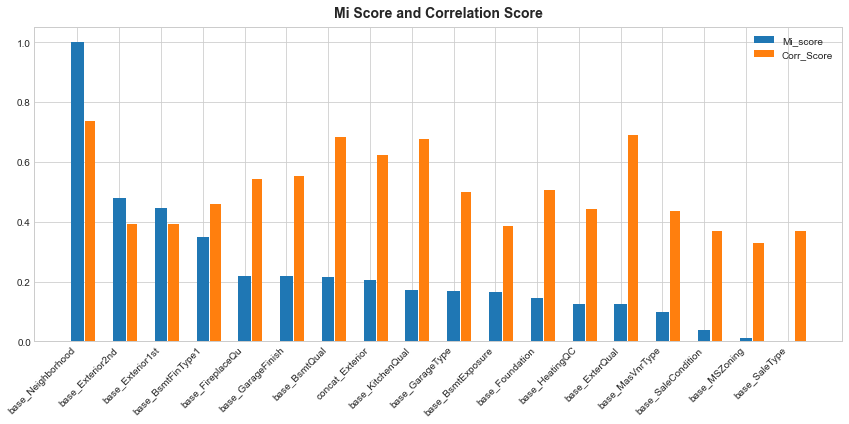

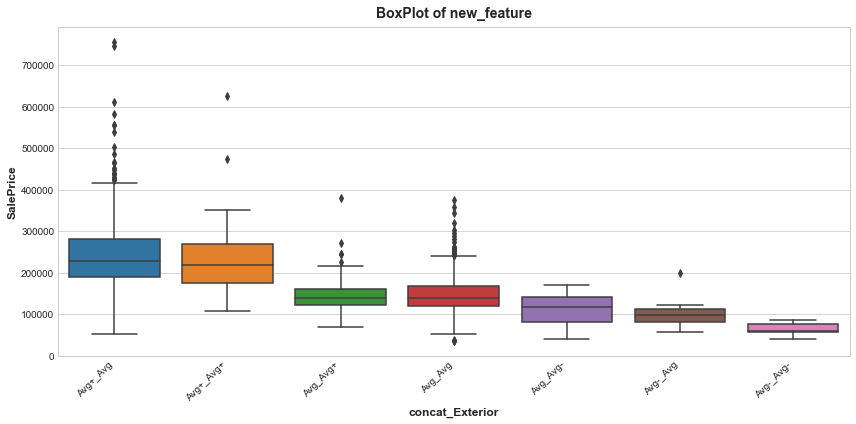

In [138]:
plot_corr_mi_median_one_feature(df=data,targets=train.SalePrice,cols=base_cat,target_col='SalePrice',active_col='concat_Exterior',fill_na='missing')

rare_MSZoning


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
rare_MSZoning       0.411261    0.324632
base_SaleType       0.403521    0.370523

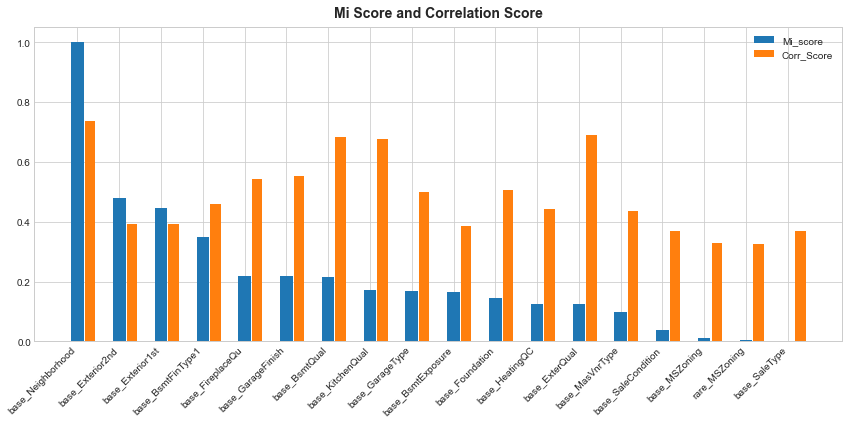

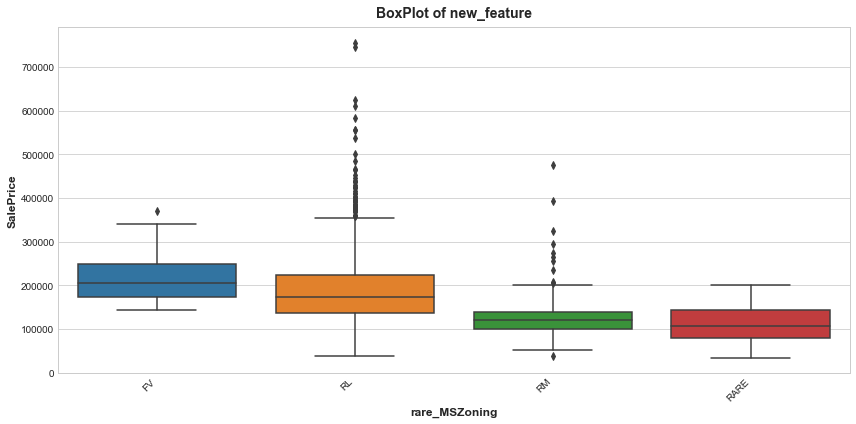



No_Alley_missing


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
No_Alley_missing    0.123325    0.123611

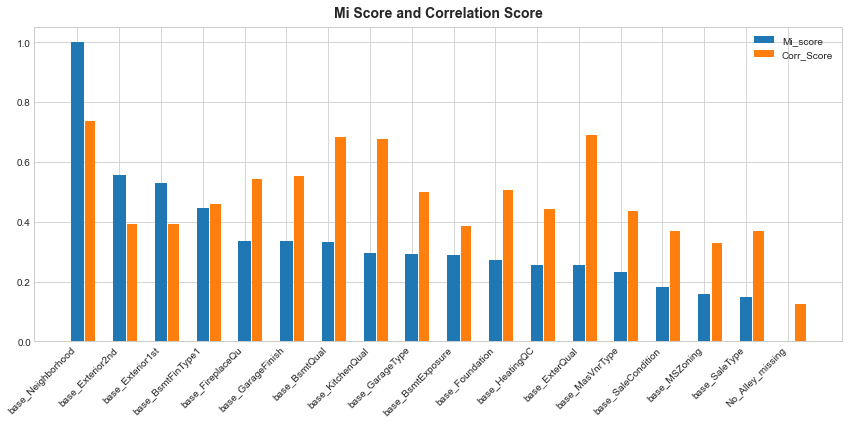

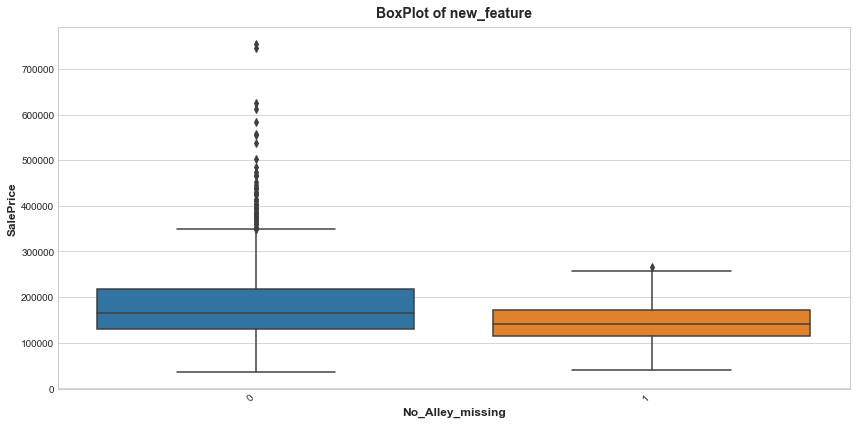



sim_LotShape


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
sim_LotShape        0.348831    0.267672

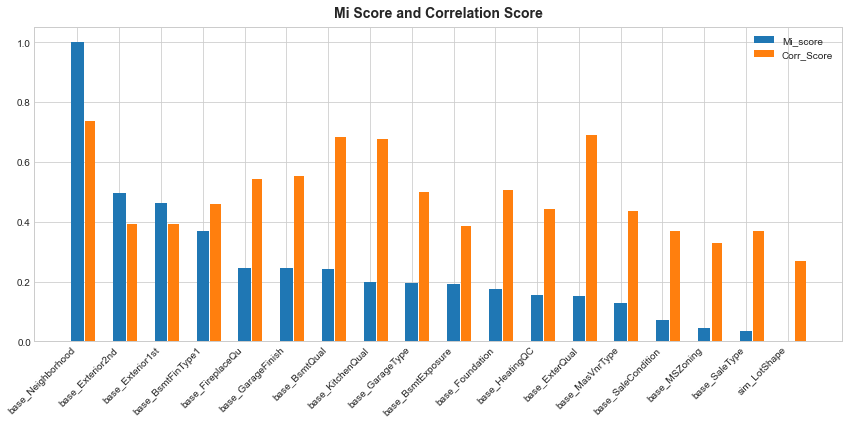

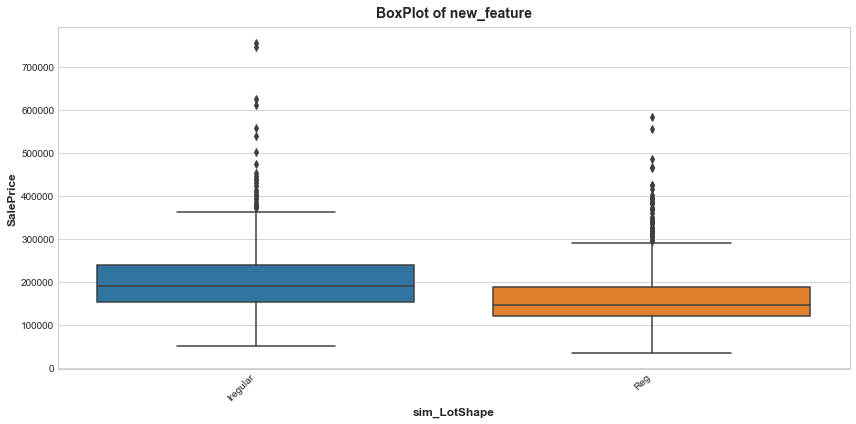



sim_LandContour


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
sim_LandContour     0.179473    0.027545

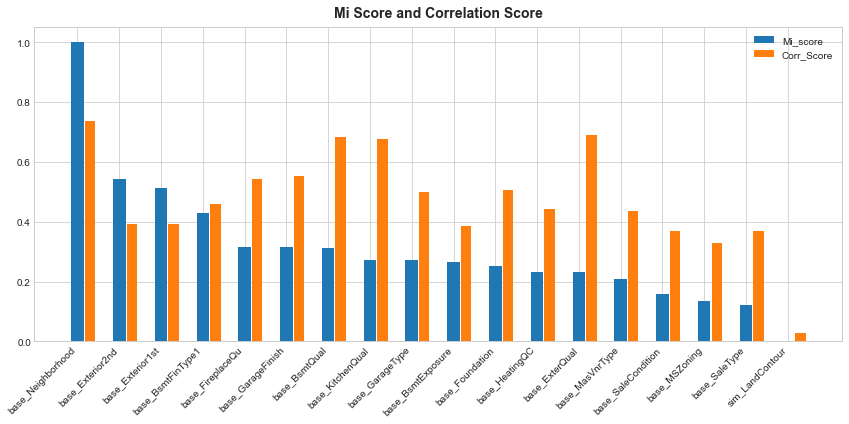

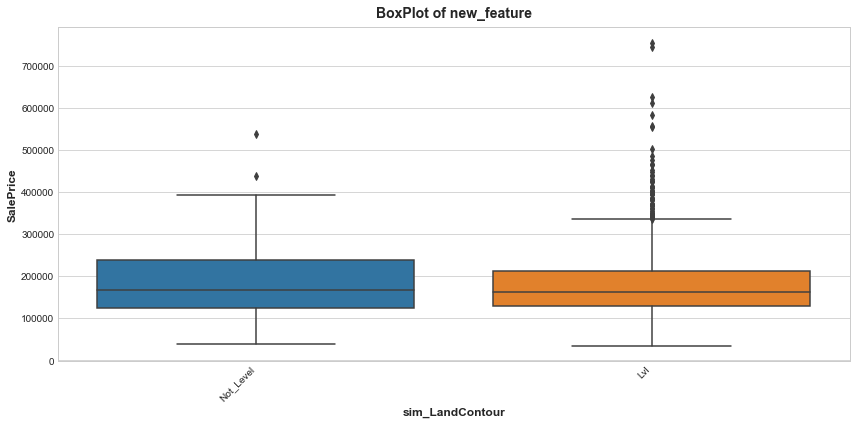



sim_LandSlope


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
sim_LandSlope       0.128400    0.051116

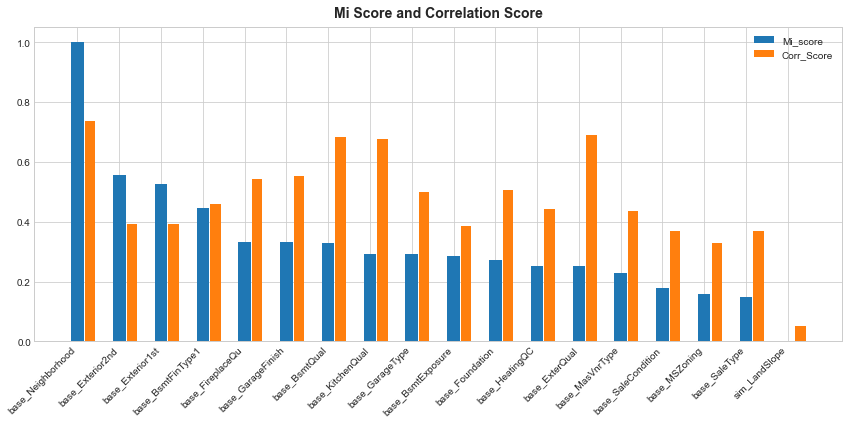

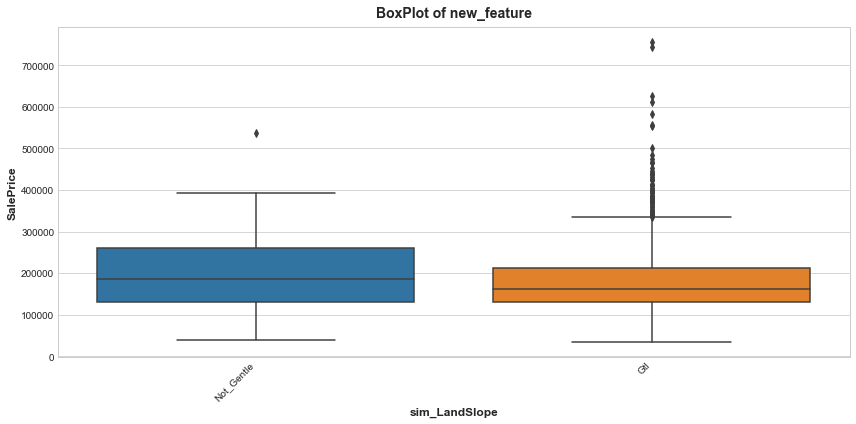



concat_LandShape


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
concat_LandShape    0.667282    0.275322
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

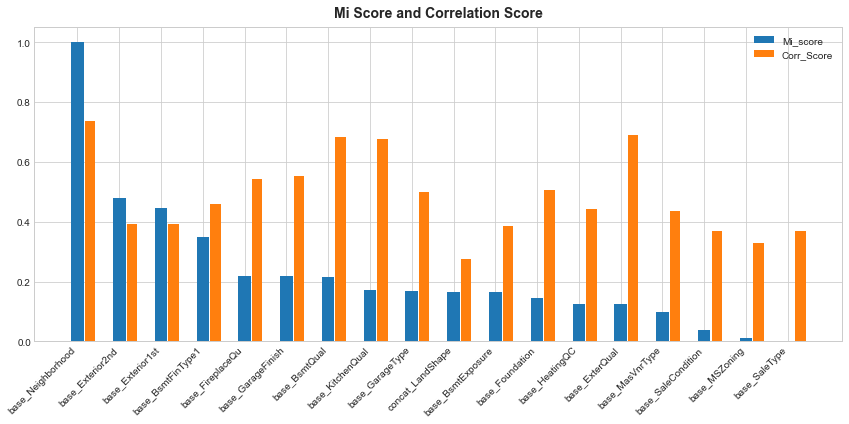

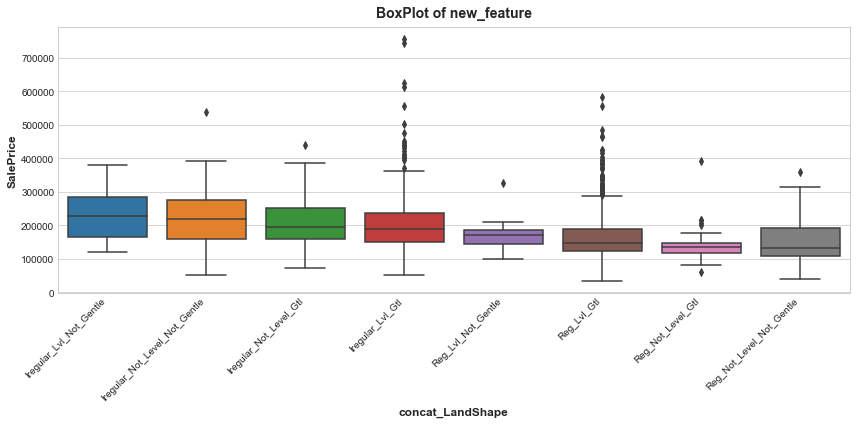



Yes_Condition1_Norm


mi_score  Corr_Score
base_Neighborhood    2.003888    0.738630
base_Exterior2nd     1.172542    0.392211
base_Exterior1st     1.116941    0.390862
base_BsmtFinType1    0.961786    0.459141
base_FireplaceQu     0.752668    0.542181
base_GarageFinish    0.752268    0.553059
base_BsmtQual        0.747080    0.681905
base_KitchenQual     0.676428    0.675721
base_GarageType      0.673624    0.499204
base_BsmtExposure    0.666649    0.386653
base_Foundation      0.637097    0.506328
base_HeatingQC       0.603568    0.442154
base_ExterQual       0.602146    0.690933
base_MasVnrType      0.558353    0.434537
base_SaleCondition   0.466175    0.368100
base_MSZoning        0.423127    0.327963
base_SaleType        0.403521    0.370523
Yes_Condition1_Norm  0.190809    0.112968

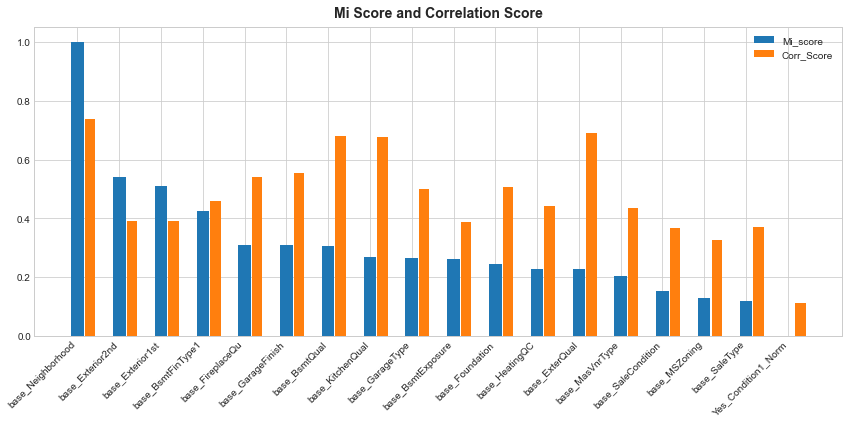

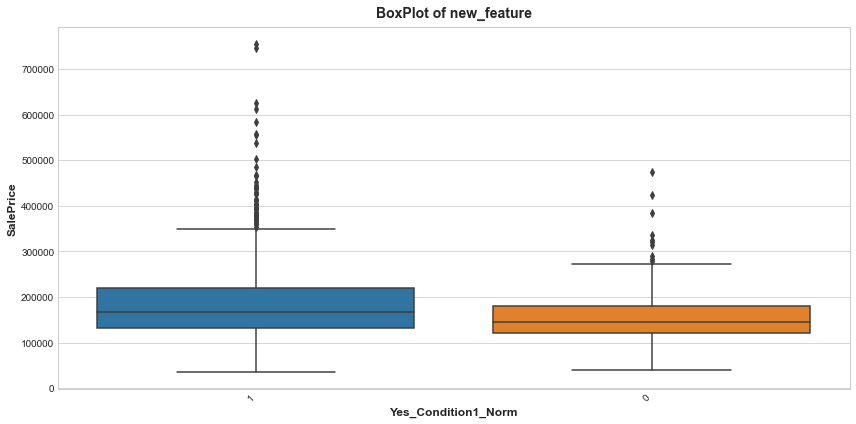



Yes_Condition2_Norm


mi_score  Corr_Score
base_Neighborhood    2.003888    0.738630
base_Exterior2nd     1.172542    0.392211
base_Exterior1st     1.116941    0.390862
base_BsmtFinType1    0.961786    0.459141
base_FireplaceQu     0.752668    0.542181
base_GarageFinish    0.752268    0.553059
base_BsmtQual        0.747080    0.681905
base_KitchenQual     0.676428    0.675721
base_GarageType      0.673624    0.499204
base_BsmtExposure    0.666649    0.386653
base_Foundation      0.637097    0.506328
base_HeatingQC       0.603568    0.442154
base_ExterQual       0.602146    0.690933
base_MasVnrType      0.558353    0.434537
base_SaleCondition   0.466175    0.368100
base_MSZoning        0.423127    0.327963
base_SaleType        0.403521    0.370523
Yes_Condition2_Norm  0.037640    0.030676

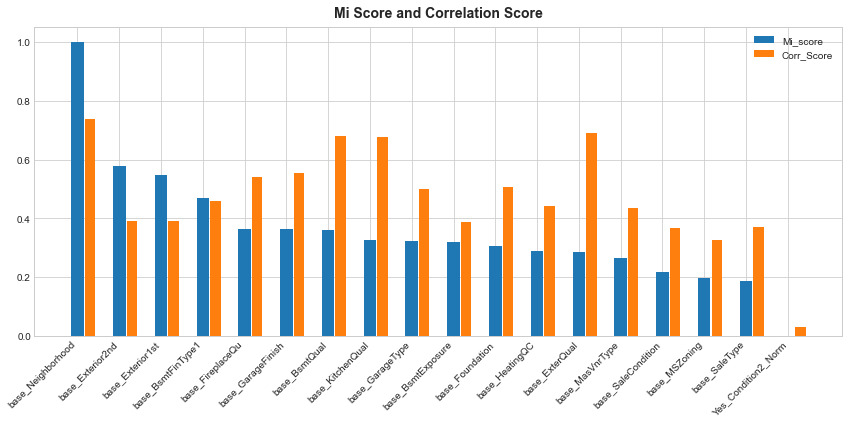

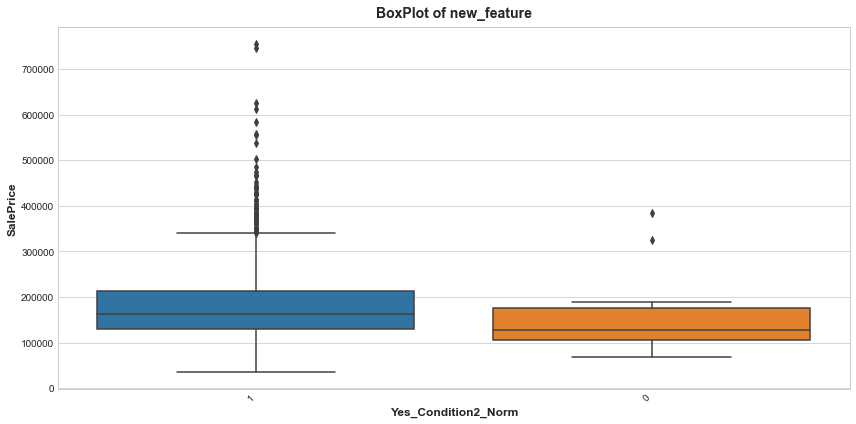



total_Condition


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
total_Condition     0.220295    0.112983

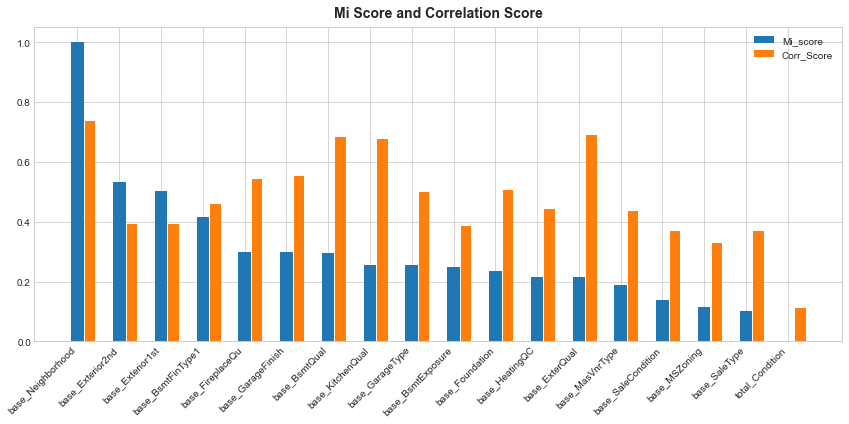



Yes_BldgType_1Fam


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
Yes_BldgType_1Fam   0.216705    0.137483

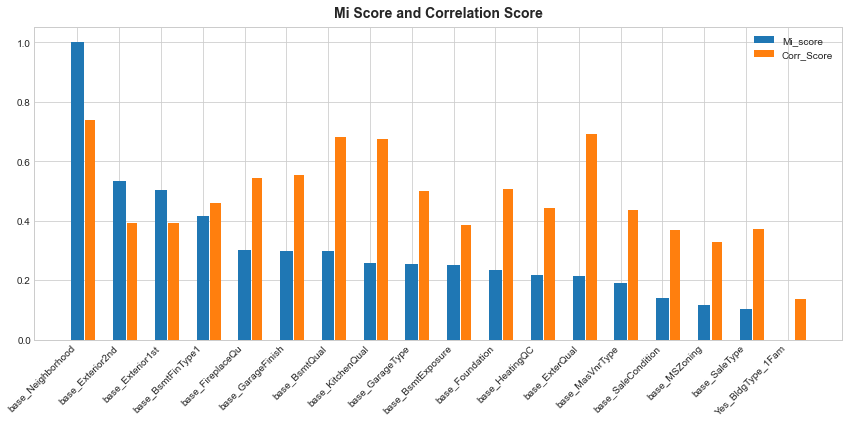



HouseStyle_Desc


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
HouseStyle_Desc     0.721220    0.293790
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

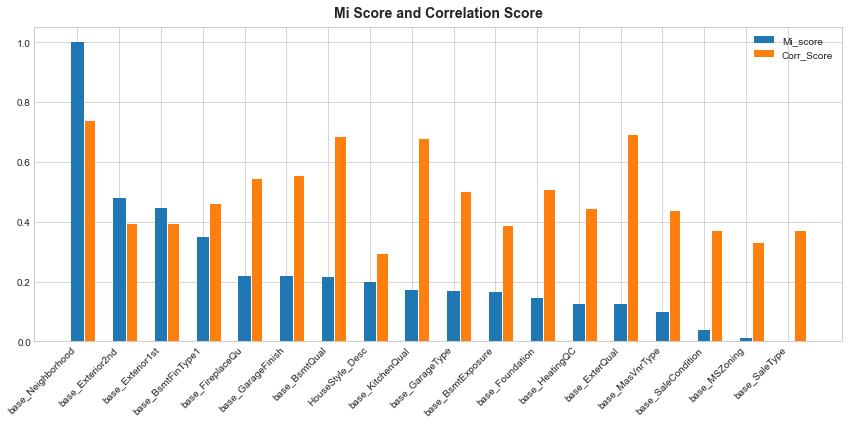

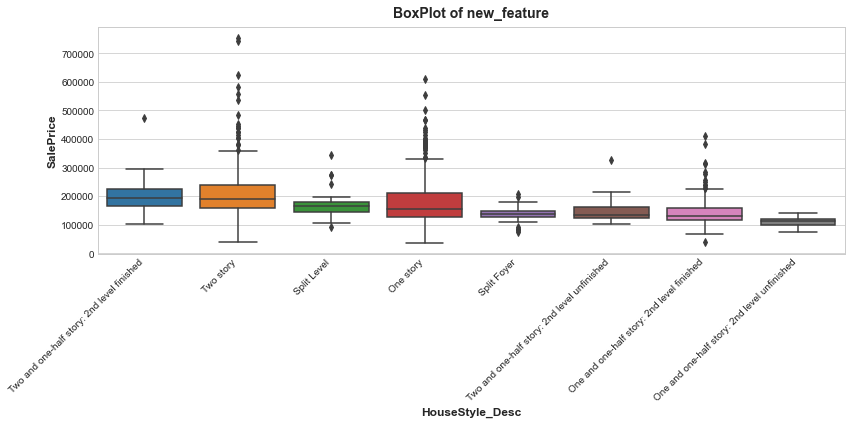



HouseStyle_Story


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
HouseStyle_Story    0.649341    0.283306
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

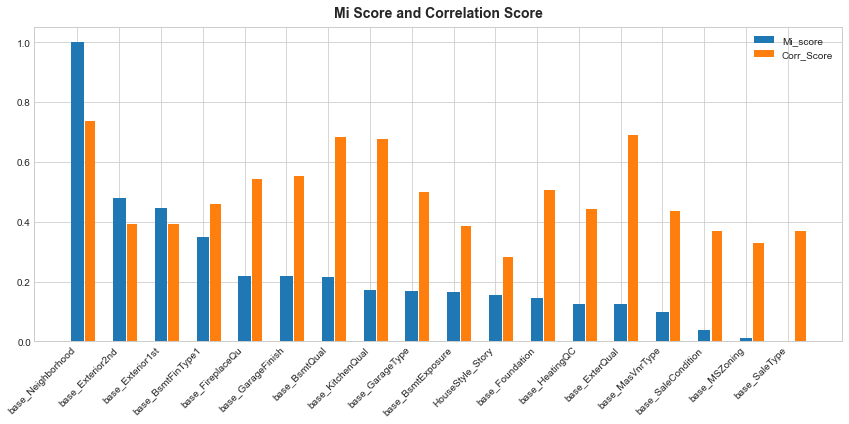

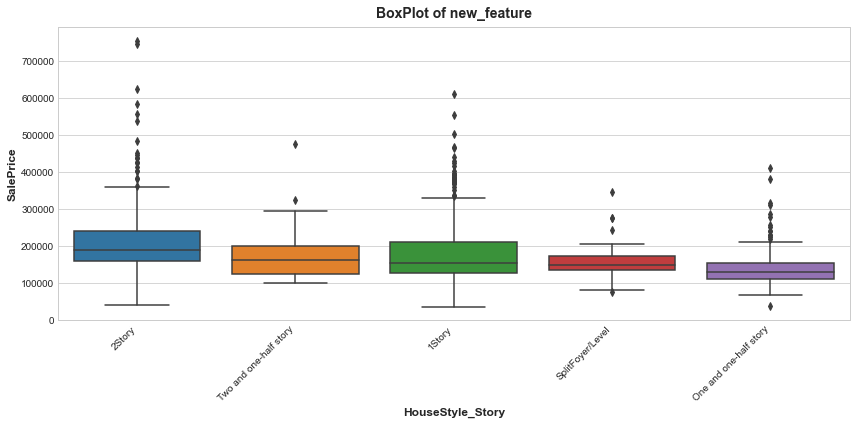



HouseStyle_finished


mi_score  Corr_Score
base_Neighborhood    2.003888    0.738630
base_Exterior2nd     1.172542    0.392211
base_Exterior1st     1.116941    0.390862
base_BsmtFinType1    0.961786    0.459141
base_FireplaceQu     0.752668    0.542181
base_GarageFinish    0.752268    0.553059
base_BsmtQual        0.747080    0.681905
base_KitchenQual     0.676428    0.675721
base_GarageType      0.673624    0.499204
base_BsmtExposure    0.666649    0.386653
base_Foundation      0.637097    0.506328
base_HeatingQC       0.603568    0.442154
base_ExterQual       0.602146    0.690933
base_MasVnrType      0.558353    0.434537
base_SaleCondition   0.466175    0.368100
base_MSZoning        0.423127    0.327963
base_SaleType        0.403521    0.370523
HouseStyle_finished  0.175680    0.151284

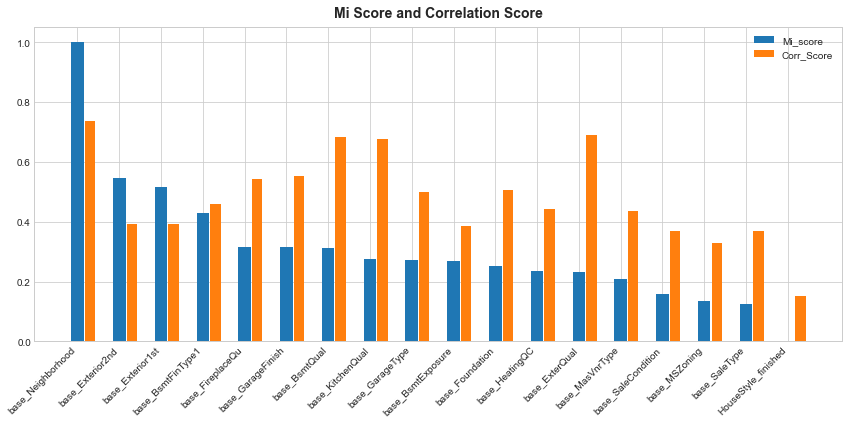

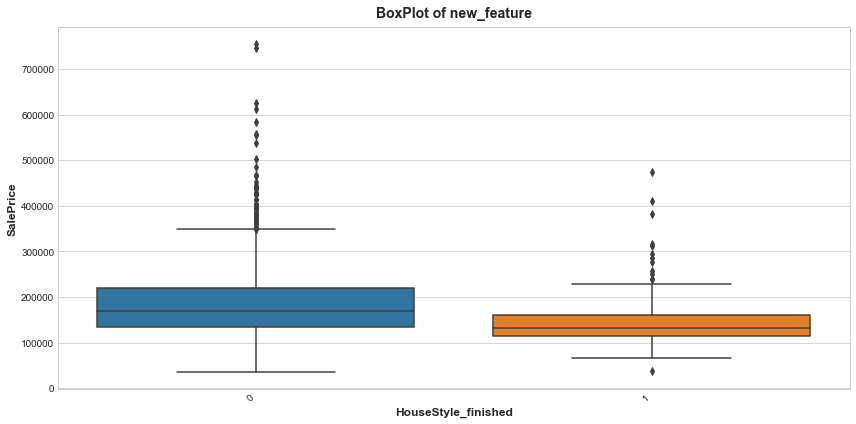



HStyle_Price_Grade


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
HStyle_Price_Grade  0.512530    0.269373
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

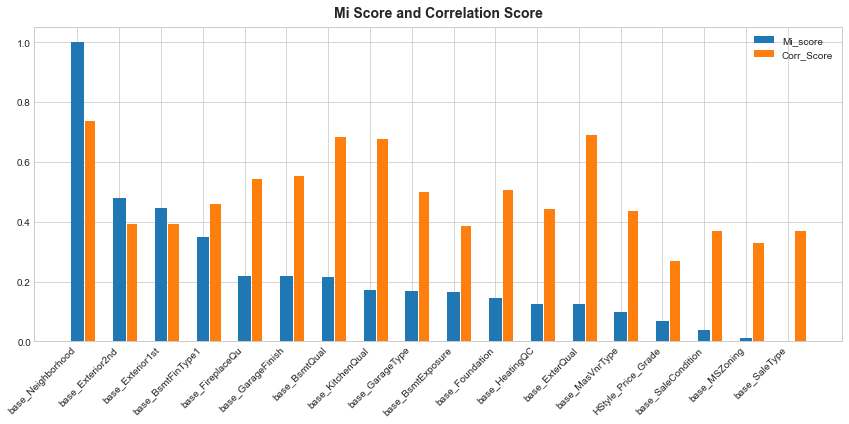

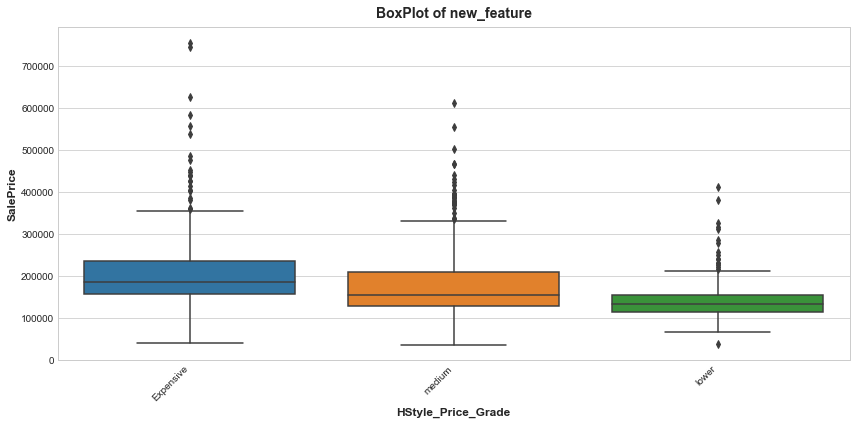



Roof_Hip/Gable


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
Roof_Hip/Gable      0.277865    0.224744

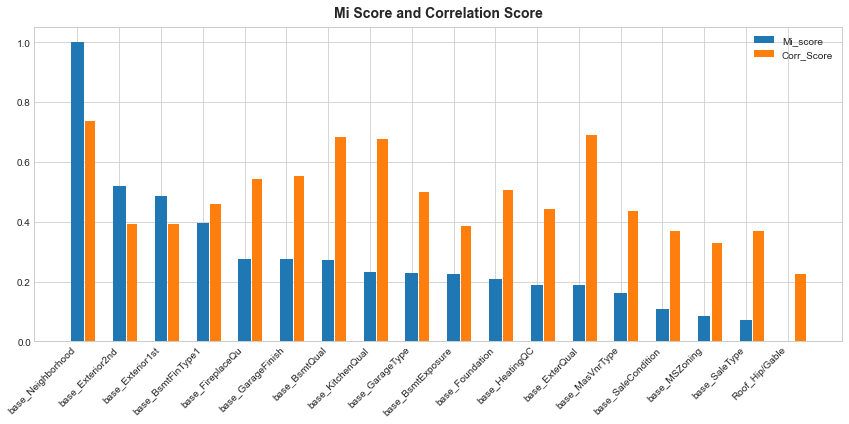

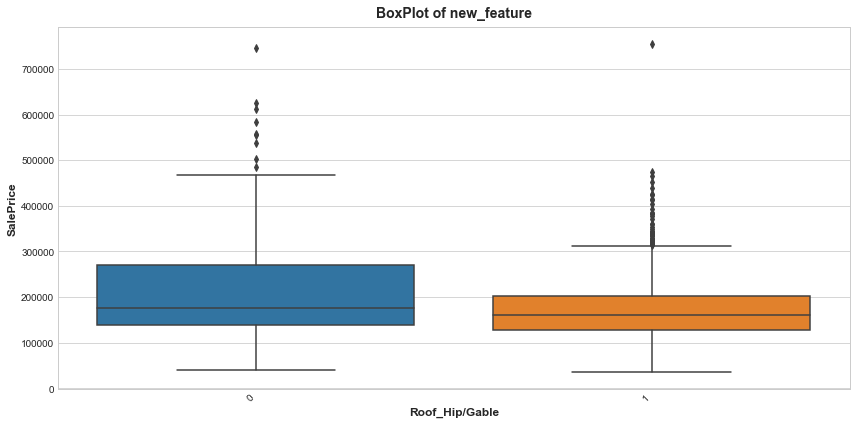



rare_Exterior1st


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
rare_Exterior1st    1.052497    0.377976
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

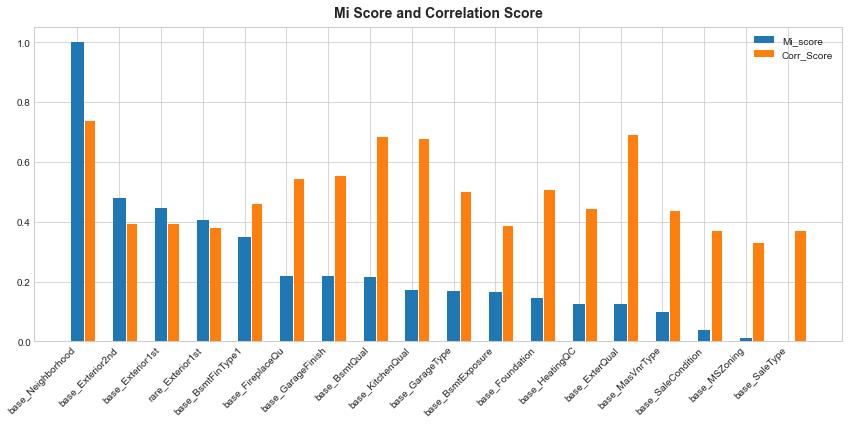

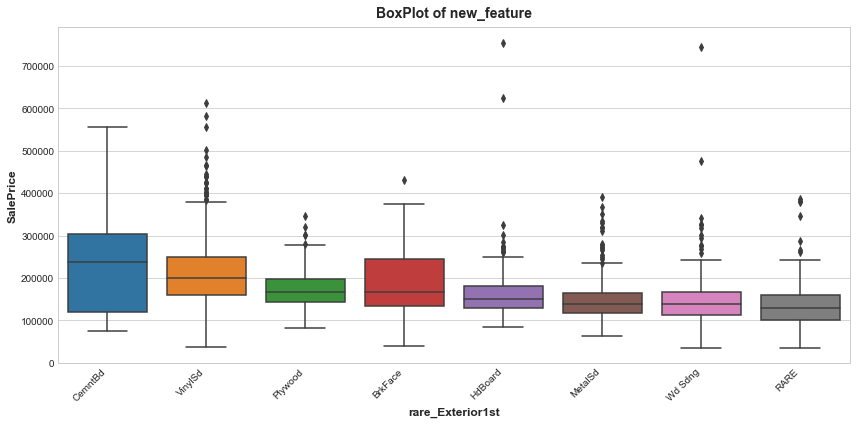



rare_Exterior2nd


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
rare_Exterior2nd    1.062633    0.364438
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

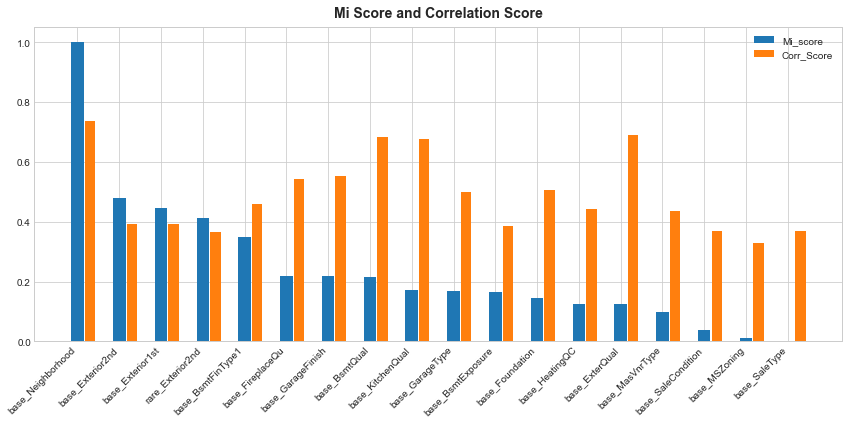

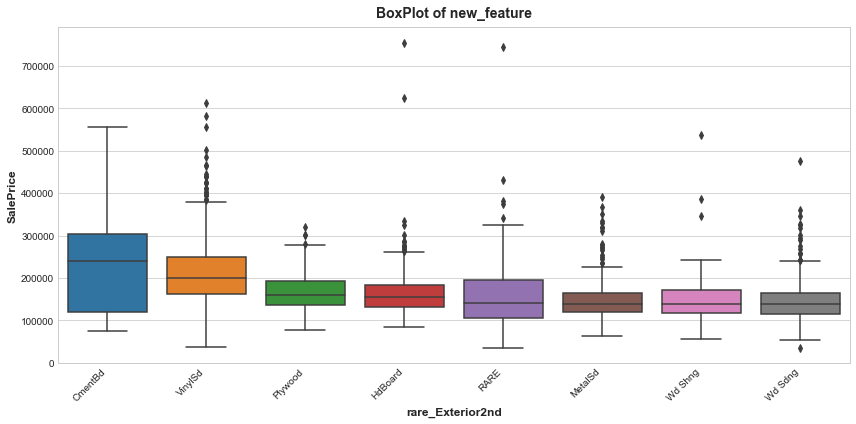



concat_Exterior


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
concat_Exterior     0.732471    0.622303
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

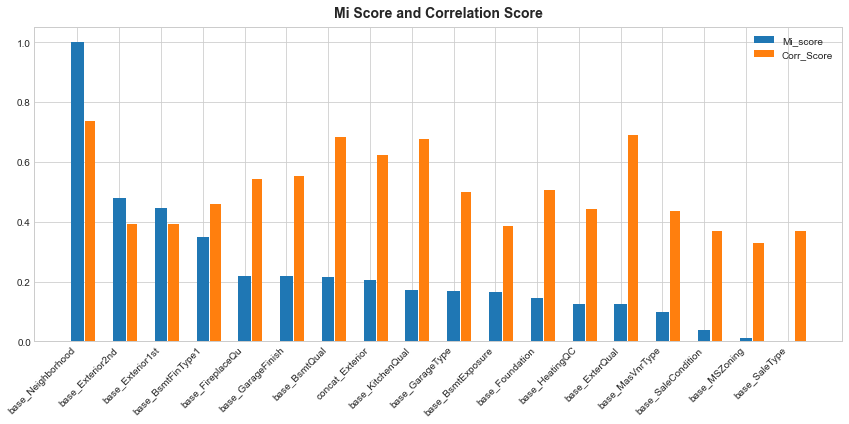

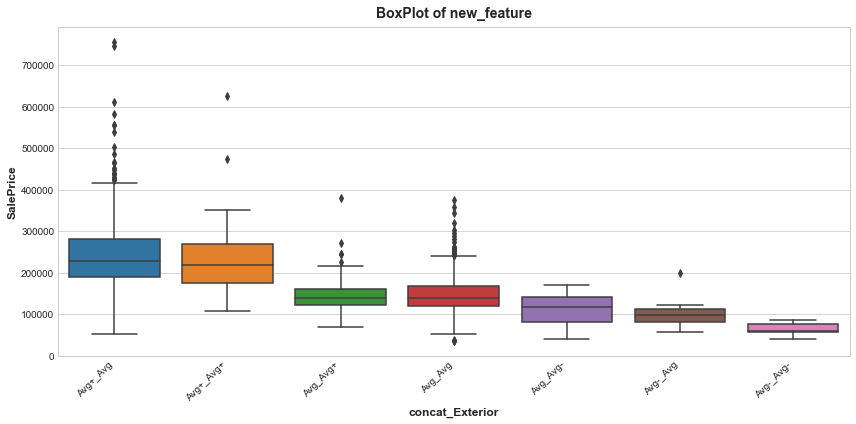



!Mason_Exist1


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
!Mason_Exist1       0.341987    0.367456

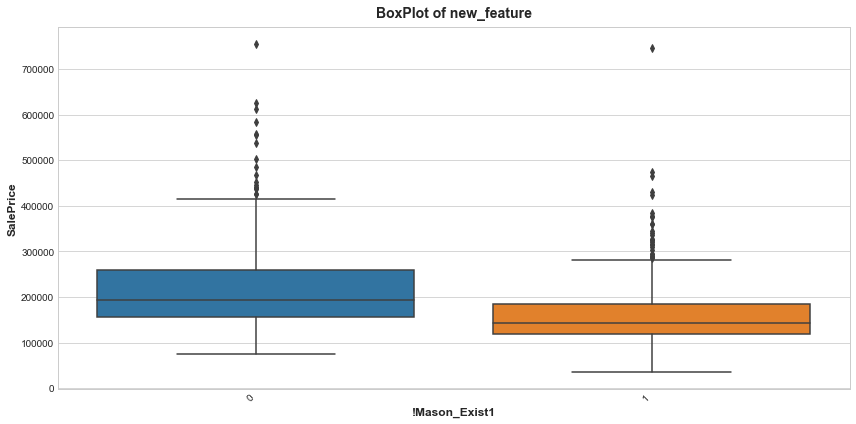



Mason_Exist


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
Mason_Exist         0.341987    0.367456

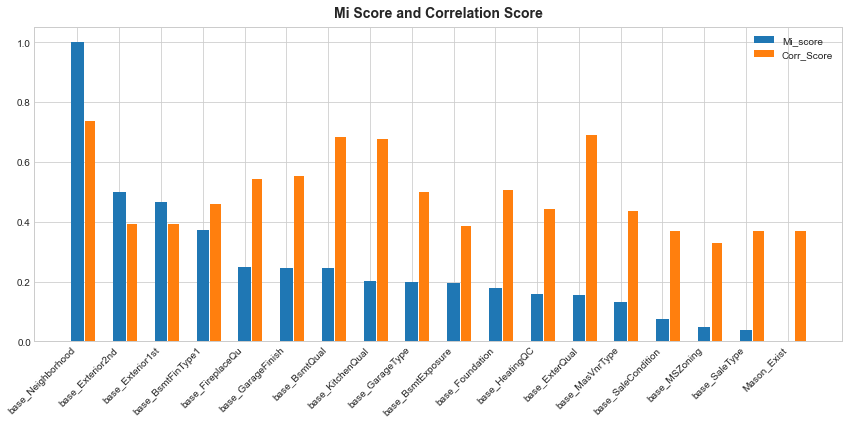



ExterQual_Price_grade


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
ExterQual_Price_grade  0.499596    0.619170
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523

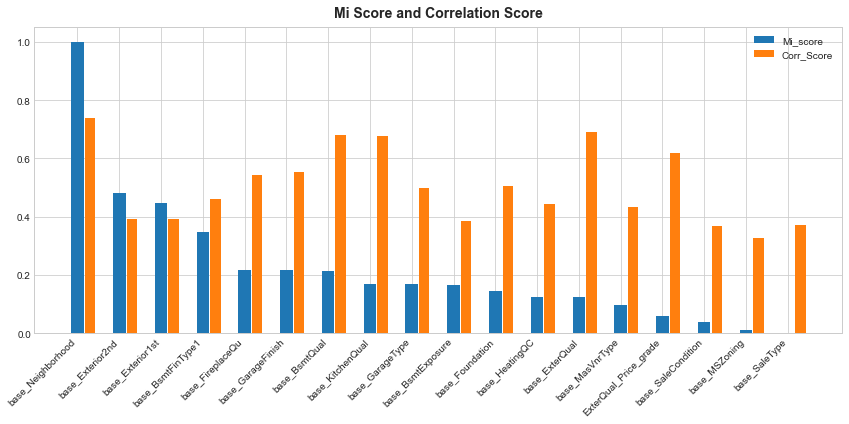

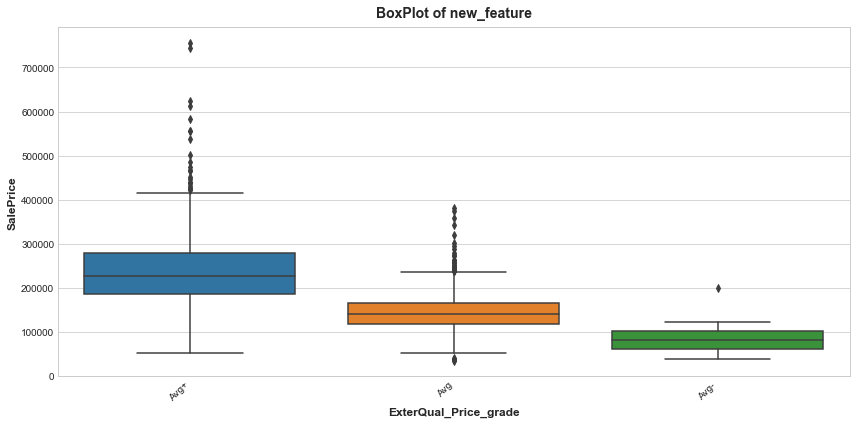



ExterQual_Price_grade1


mi_score  Corr_Score
base_Neighborhood       2.003888    0.738630
base_Exterior2nd        1.172542    0.392211
base_Exterior1st        1.116941    0.390862
base_BsmtFinType1       0.961786    0.459141
base_FireplaceQu        0.752668    0.542181
base_GarageFinish       0.752268    0.553059
base_BsmtQual           0.747080    0.681905
base_KitchenQual        0.676428    0.675721
base_GarageType         0.673624    0.499204
base_BsmtExposure       0.666649    0.386653
base_Foundation         0.637097    0.506328
base_HeatingQC          0.603568    0.442154
base_ExterQual          0.602146    0.690933
base_MasVnrType         0.558353    0.434537
ExterQual_Price_grade1  0.499596    0.619170
base_SaleCondition      0.466175    0.368100
base_MSZoning           0.423127    0.327963
base_SaleType           0.403521    0.370523

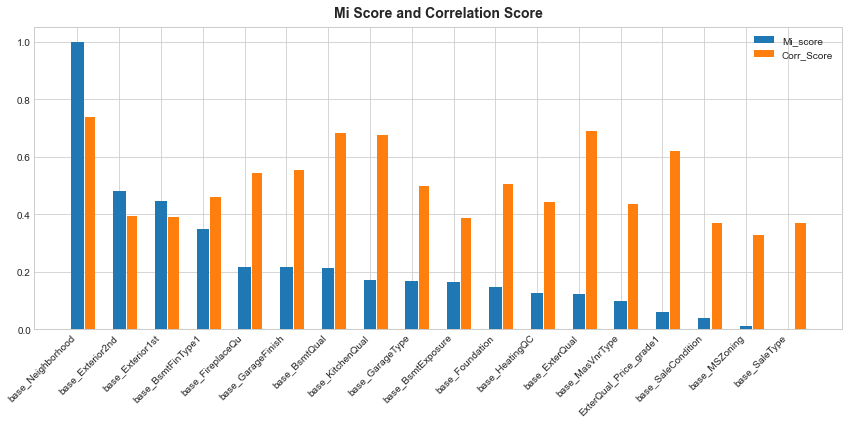

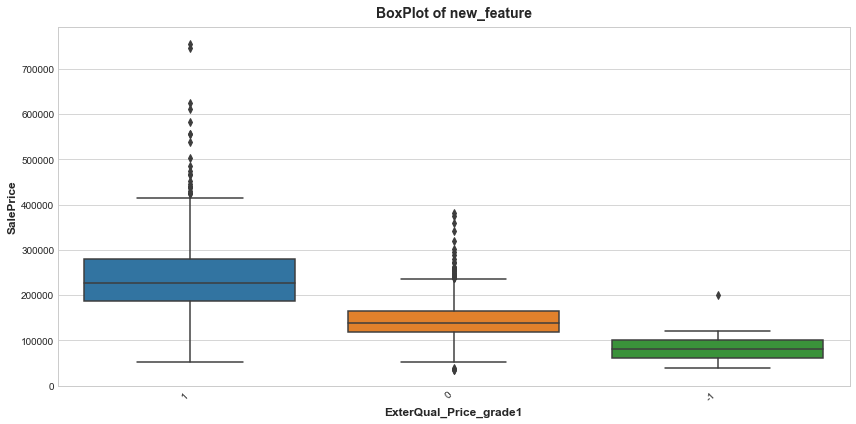



ExterCond_Price_grade


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523
ExterCond_Price_grade  0.225229    0.152349

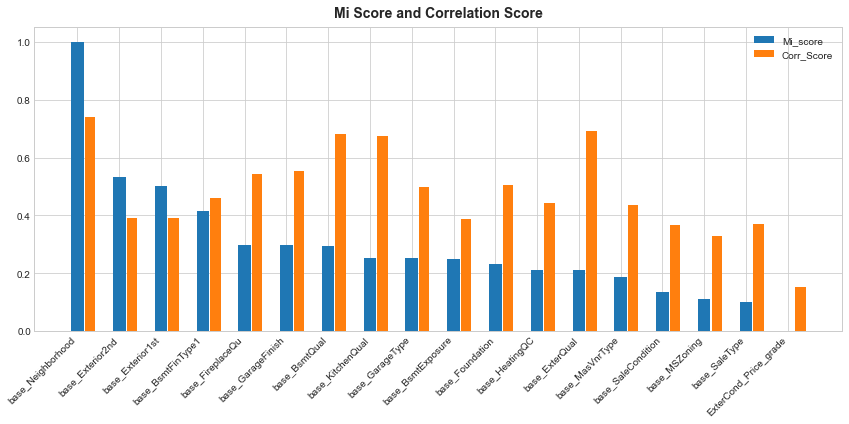

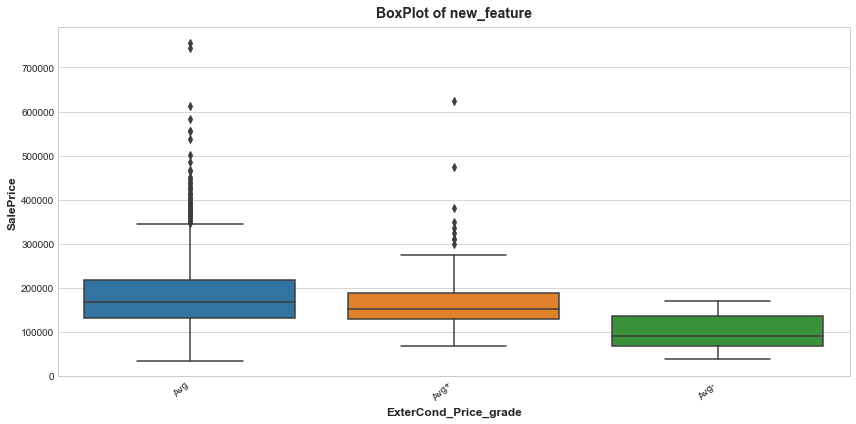



ExterCond_Price_grade1


mi_score  Corr_Score
base_Neighborhood       2.003888    0.738630
base_Exterior2nd        1.172542    0.392211
base_Exterior1st        1.116941    0.390862
base_BsmtFinType1       0.961786    0.459141
base_FireplaceQu        0.752668    0.542181
base_GarageFinish       0.752268    0.553059
base_BsmtQual           0.747080    0.681905
base_KitchenQual        0.676428    0.675721
base_GarageType         0.673624    0.499204
base_BsmtExposure       0.666649    0.386653
base_Foundation         0.637097    0.506328
base_HeatingQC          0.603568    0.442154
base_ExterQual          0.602146    0.690933
base_MasVnrType         0.558353    0.434537
base_SaleCondition      0.466175    0.368100
base_MSZoning           0.423127    0.327963
base_SaleType           0.403521    0.370523
ExterCond_Price_grade1  0.225229    0.152349

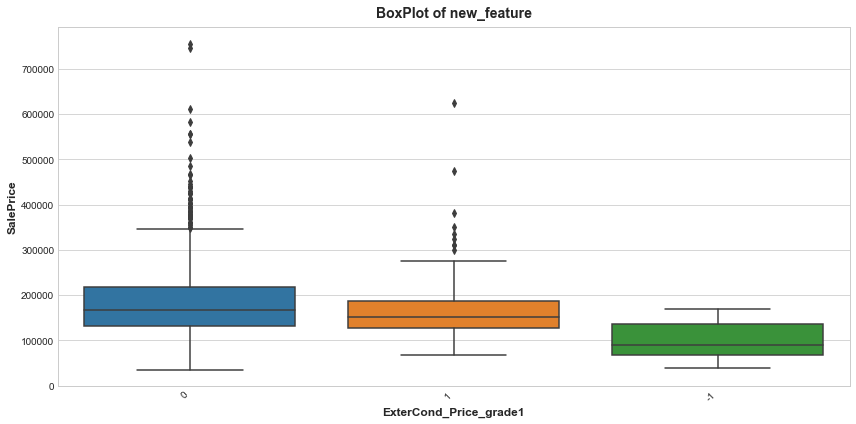



concat_Exterior


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
concat_Exterior     0.732471    0.622303
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

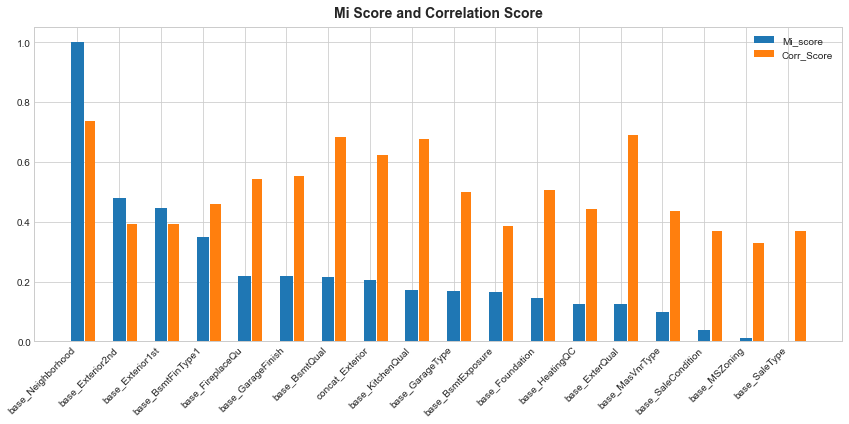

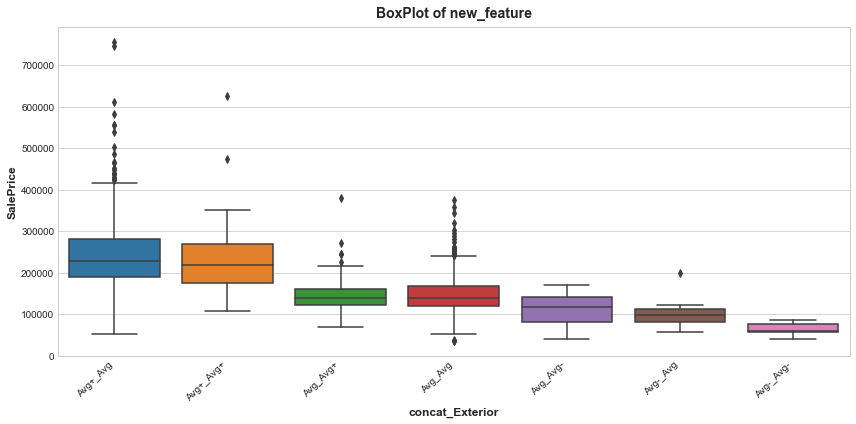



total_ExtQualCond


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
total_ExtQualCond   0.556914    0.539575
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

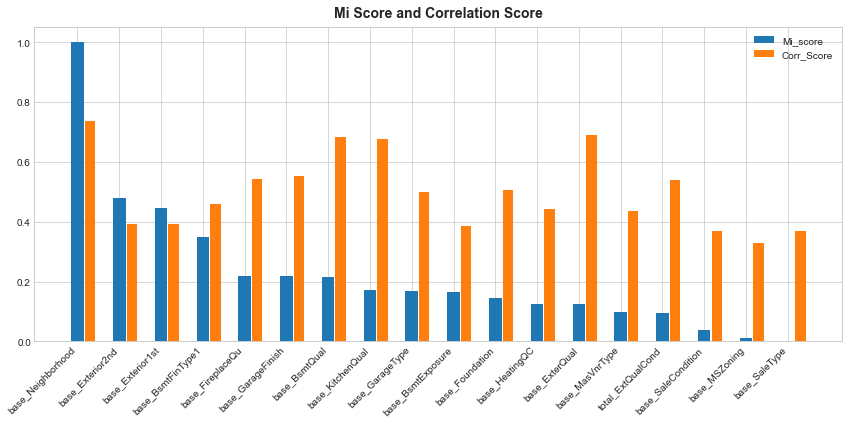

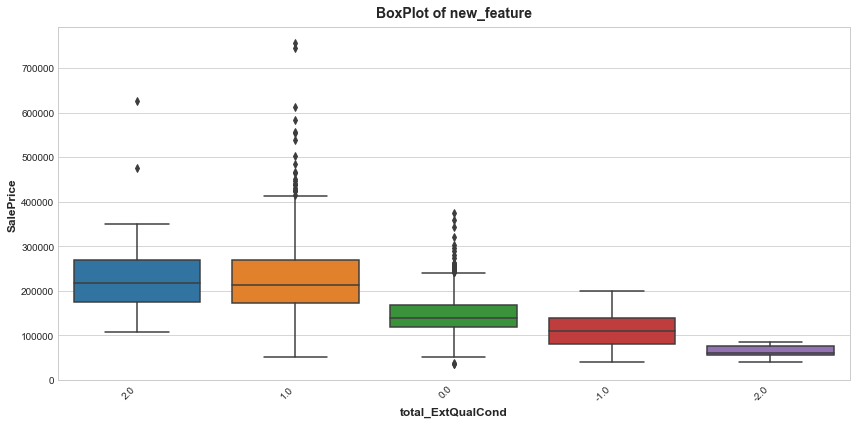



rare_Foundation


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
rare_Foundation     0.571671    0.503106
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

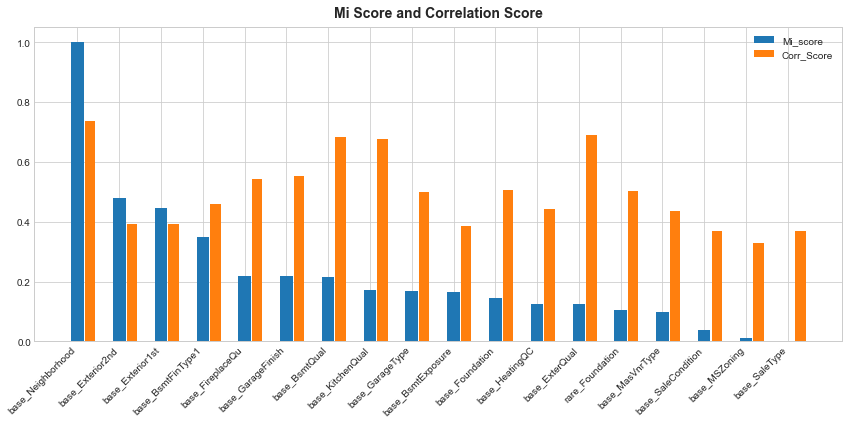

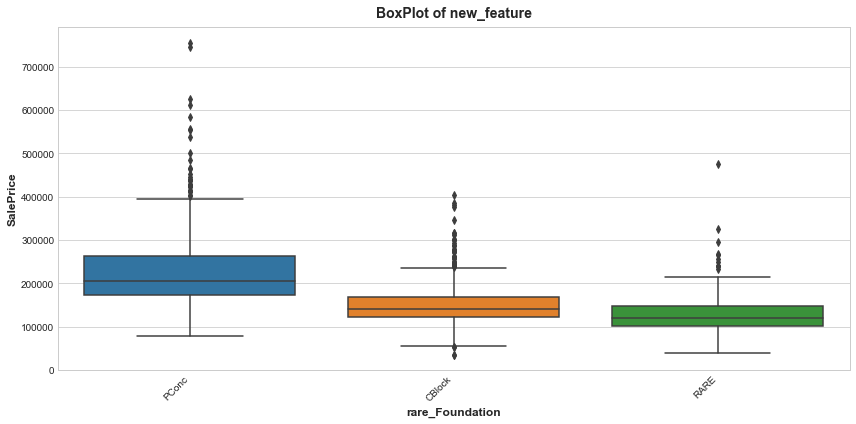



BsmtQual_Price_grade


mi_score  Corr_Score
base_Neighborhood     2.003888    0.738630
base_Exterior2nd      1.172542    0.392211
base_Exterior1st      1.116941    0.390862
base_BsmtFinType1     0.961786    0.459141
base_FireplaceQu      0.752668    0.542181
base_GarageFinish     0.752268    0.553059
base_BsmtQual         0.747080    0.681905
base_KitchenQual      0.676428    0.675721
base_GarageType       0.673624    0.499204
base_BsmtExposure     0.666649    0.386653
base_Foundation       0.637097    0.506328
base_HeatingQC        0.603568    0.442154
base_ExterQual        0.602146    0.690933
base_MasVnrType       0.558353    0.434537
BsmtQual_Price_grade  0.539000    0.543014
base_SaleCondition    0.466175    0.368100
base_MSZoning         0.423127    0.327963
base_SaleType         0.403521    0.370523

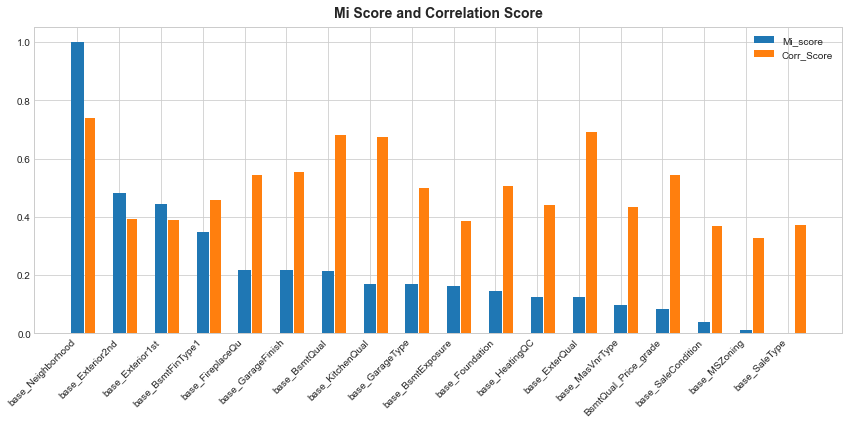

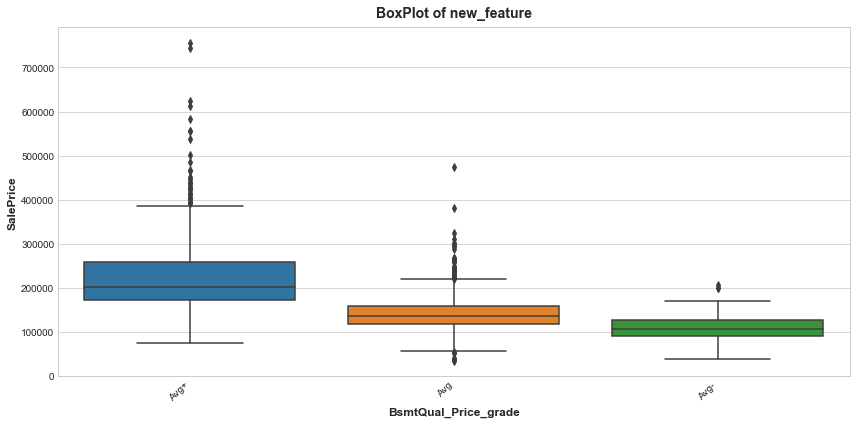



BsmtQual_Price_grade1


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
BsmtQual_Price_grade1  0.539000    0.543014
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523

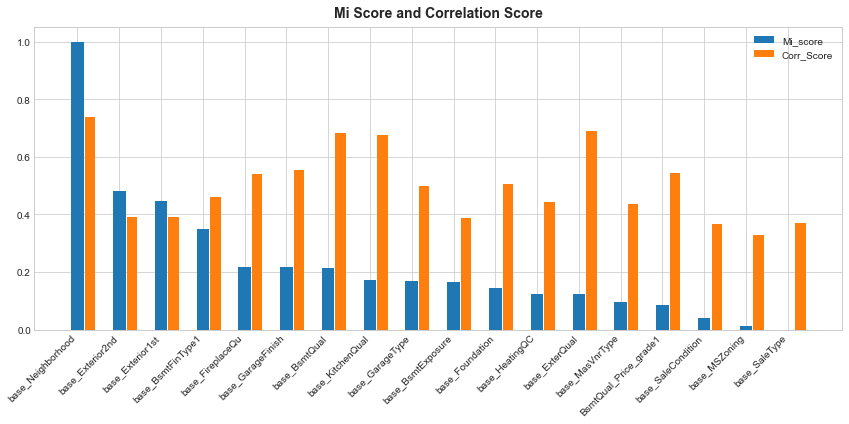

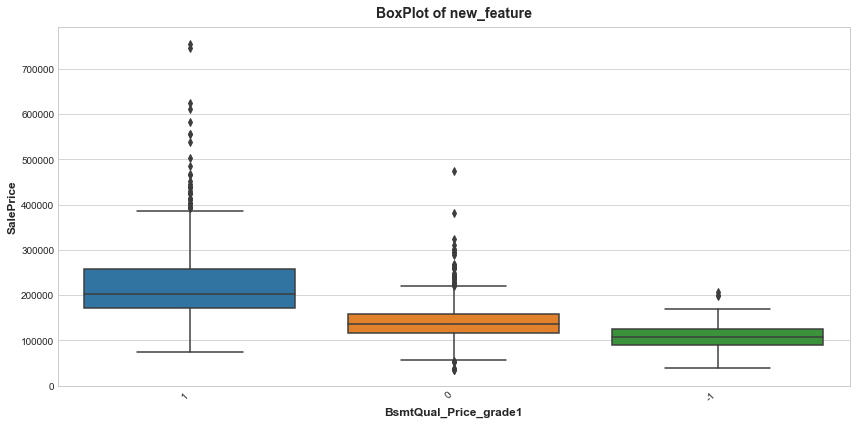



BsmtCond_Price_grade


mi_score  Corr_Score
base_Neighborhood     2.003888    0.738630
base_Exterior2nd      1.172542    0.392211
base_Exterior1st      1.116941    0.390862
base_BsmtFinType1     0.961786    0.459141
base_FireplaceQu      0.752668    0.542181
base_GarageFinish     0.752268    0.553059
base_BsmtQual         0.747080    0.681905
base_KitchenQual      0.676428    0.675721
base_GarageType       0.673624    0.499204
base_BsmtExposure     0.666649    0.386653
base_Foundation       0.637097    0.506328
base_HeatingQC        0.603568    0.442154
base_ExterQual        0.602146    0.690933
base_MasVnrType       0.558353    0.434537
base_SaleCondition    0.466175    0.368100
base_MSZoning         0.423127    0.327963
base_SaleType         0.403521    0.370523
BsmtCond_Price_grade  0.255772    0.224230

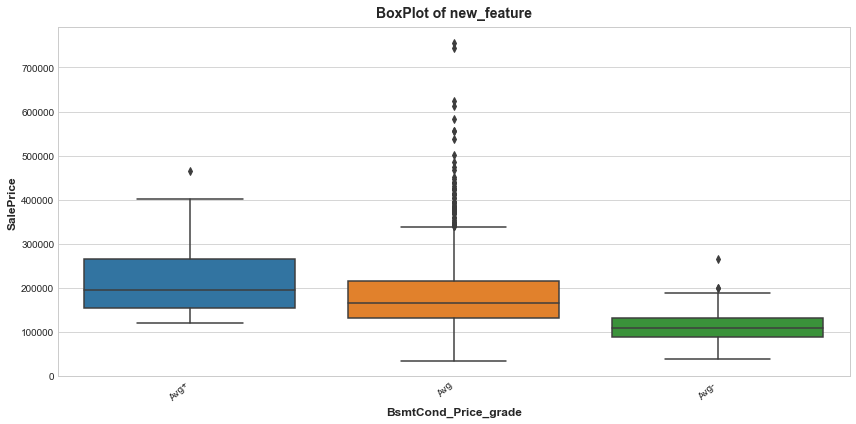



BsmtCond_Price_grade1


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523
BsmtCond_Price_grade1  0.255772    0.224230

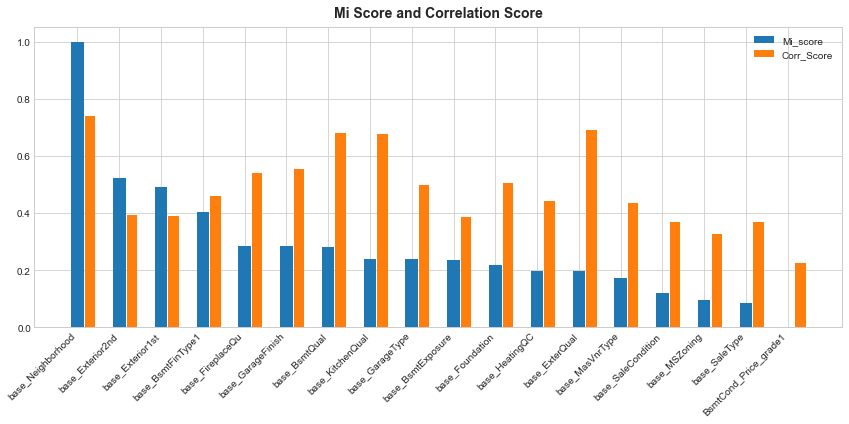

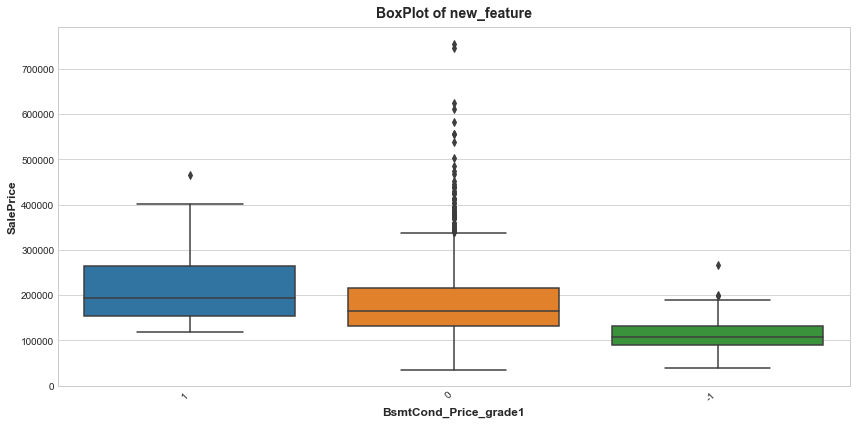



concat_BsmtQualCond


mi_score  Corr_Score
base_Neighborhood    2.003888    0.738630
base_Exterior2nd     1.172542    0.392211
base_Exterior1st     1.116941    0.390862
base_BsmtFinType1    0.961786    0.459141
concat_BsmtQualCond  0.765071    0.548345
base_FireplaceQu     0.752668    0.542181
base_GarageFinish    0.752268    0.553059
base_BsmtQual        0.747080    0.681905
base_KitchenQual     0.676428    0.675721
base_GarageType      0.673624    0.499204
base_BsmtExposure    0.666649    0.386653
base_Foundation      0.637097    0.506328
base_HeatingQC       0.603568    0.442154
base_ExterQual       0.602146    0.690933
base_MasVnrType      0.558353    0.434537
base_SaleCondition   0.466175    0.368100
base_MSZoning        0.423127    0.327963
base_SaleType        0.403521    0.370523

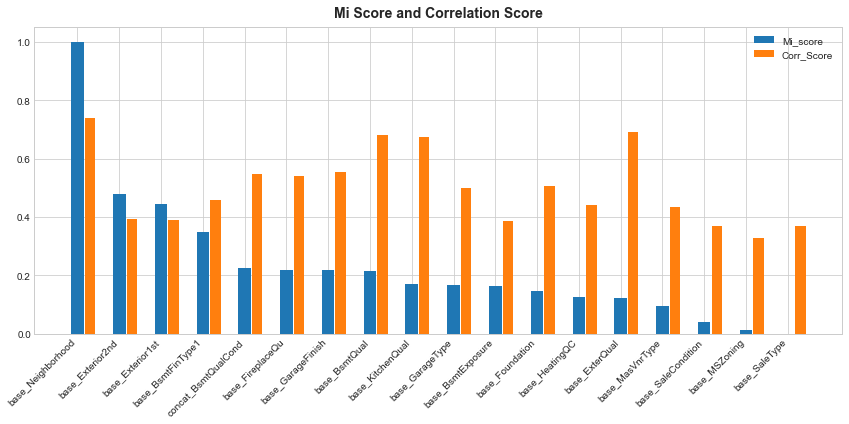



total_BsmtQualCond


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
total_BsmtQualCond  0.692398    0.545167
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

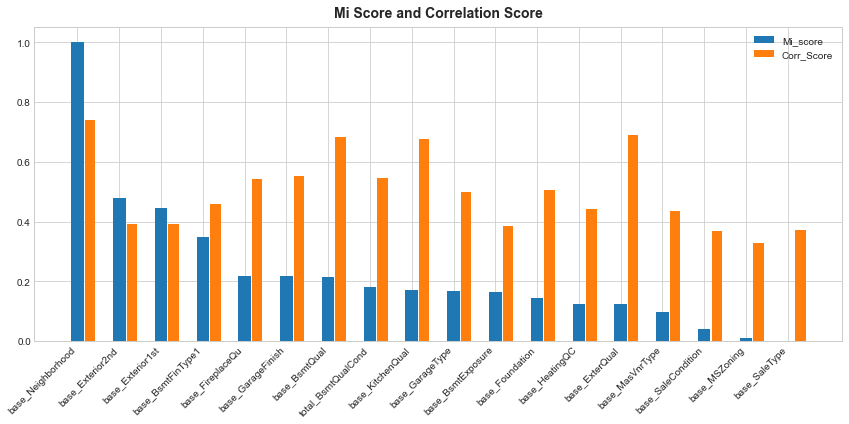

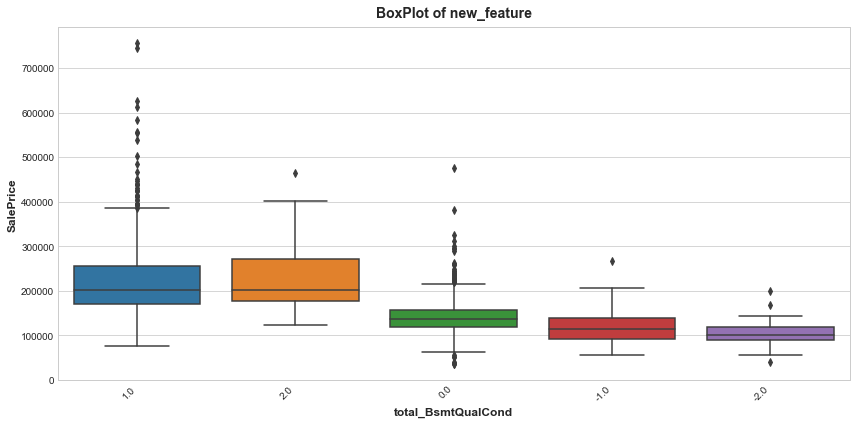



BsmtExposure_Price_grade1


mi_score  Corr_Score
base_Neighborhood          2.003888    0.738630
base_Exterior2nd           1.172542    0.392211
base_Exterior1st           1.116941    0.390862
base_BsmtFinType1          0.961786    0.459141
base_FireplaceQu           0.752668    0.542181
base_GarageFinish          0.752268    0.553059
base_BsmtQual              0.747080    0.681905
base_KitchenQual           0.676428    0.675721
base_GarageType            0.673624    0.499204
base_BsmtExposure          0.666649    0.386653
base_Foundation            0.637097    0.506328
base_HeatingQC             0.603568    0.442154
base_ExterQual             0.602146    0.690933
BsmtExposure_Price_grade1  0.582715    0.369163
base_MasVnrType            0.558353    0.434537
base_SaleCondition         0.466175    0.368100
base_MSZoning              0.423127    0.327963
base_SaleType              0.403521    0.370523

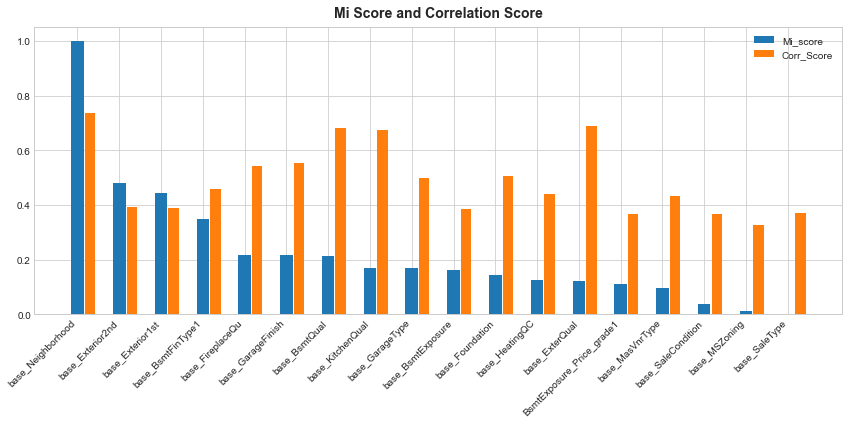



BsmtFin1_Price_grade1


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
BsmtFin1_Price_grade1  0.797298    0.458995
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523

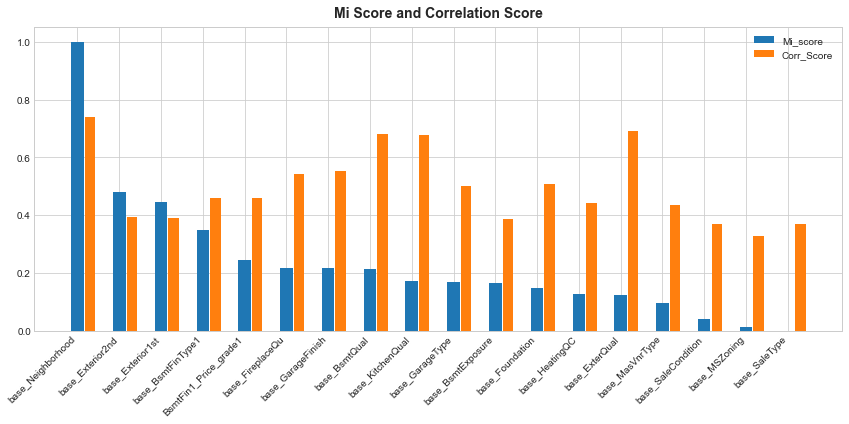

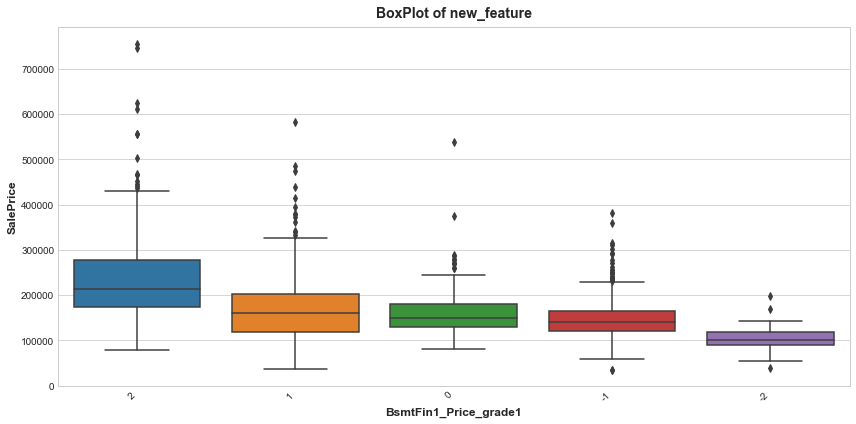



BsmtFin2_Price_grade1


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523
BsmtFin2_Price_grade1  0.320917    0.172620

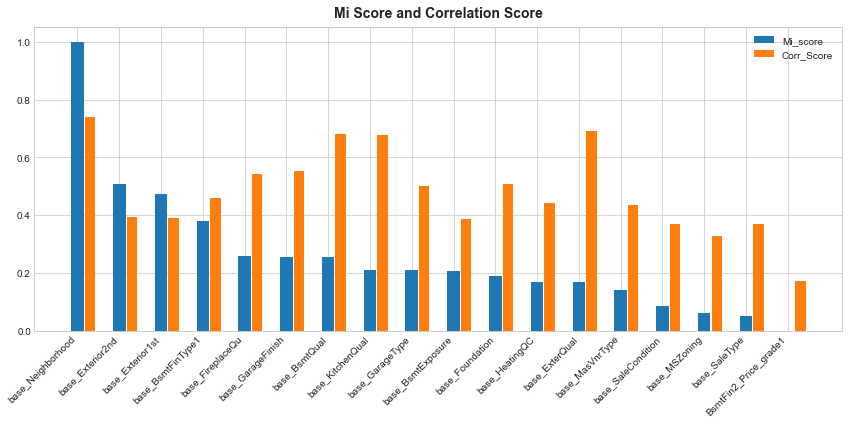

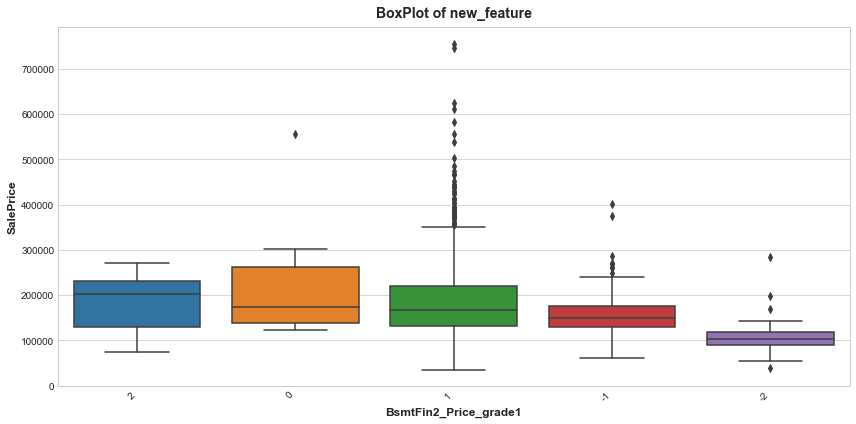



total_BsmtFin


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
total_BsmtFin       0.940075    0.459584
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523

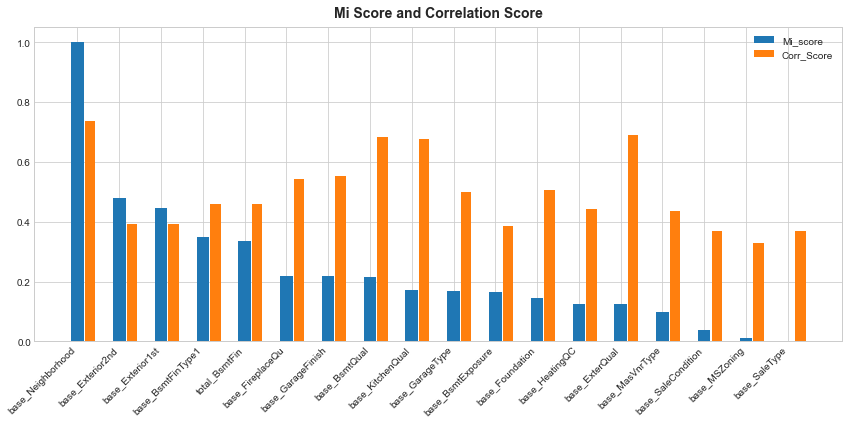

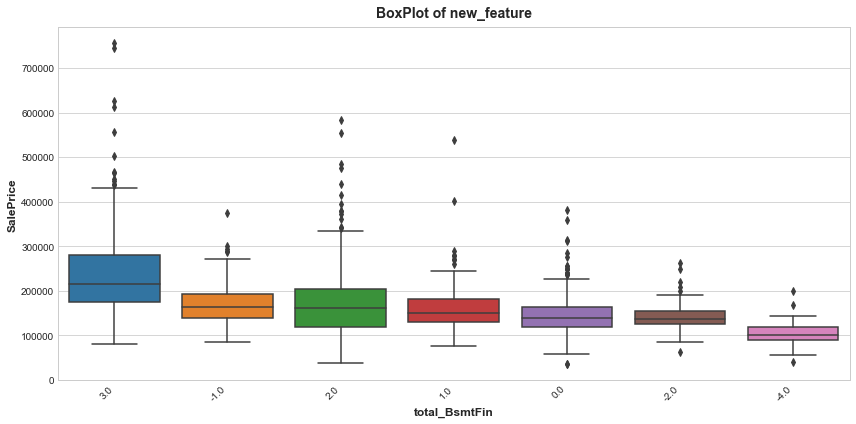



HeatingQC_Price_grade1


mi_score  Corr_Score
base_Neighborhood       2.003888    0.738630
base_Exterior2nd        1.172542    0.392211
base_Exterior1st        1.116941    0.390862
base_BsmtFinType1       0.961786    0.459141
base_FireplaceQu        0.752668    0.542181
base_GarageFinish       0.752268    0.553059
base_BsmtQual           0.747080    0.681905
base_KitchenQual        0.676428    0.675721
base_GarageType         0.673624    0.499204
base_BsmtExposure       0.666649    0.386653
base_Foundation         0.637097    0.506328
base_HeatingQC          0.603568    0.442154
base_ExterQual          0.602146    0.690933
HeatingQC_Price_grade1  0.601160    0.441990
base_MasVnrType         0.558353    0.434537
base_SaleCondition      0.466175    0.368100
base_MSZoning           0.423127    0.327963
base_SaleType           0.403521    0.370523

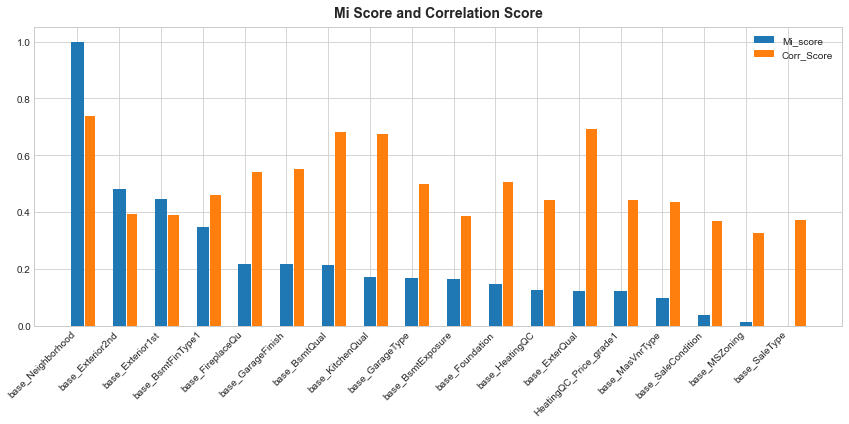

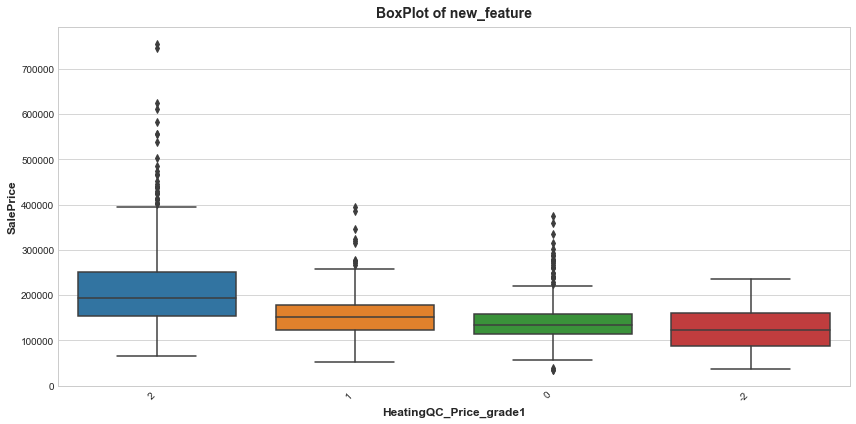



Yes_CentralAir_Y


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
Yes_CentralAir_Y    0.157975    0.251328

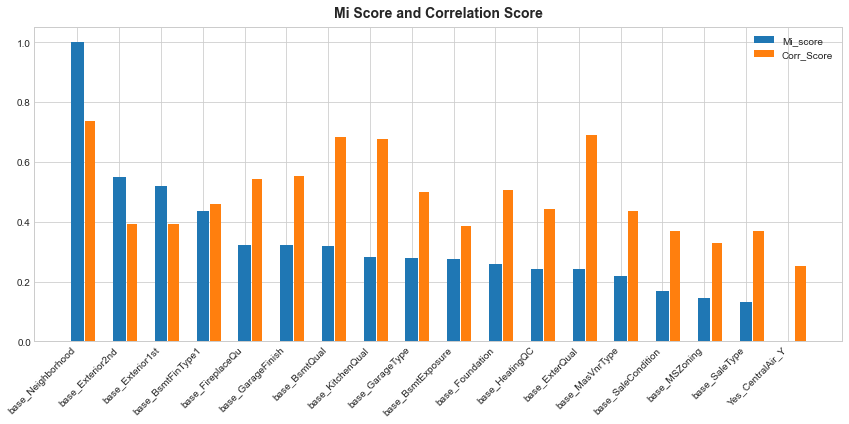

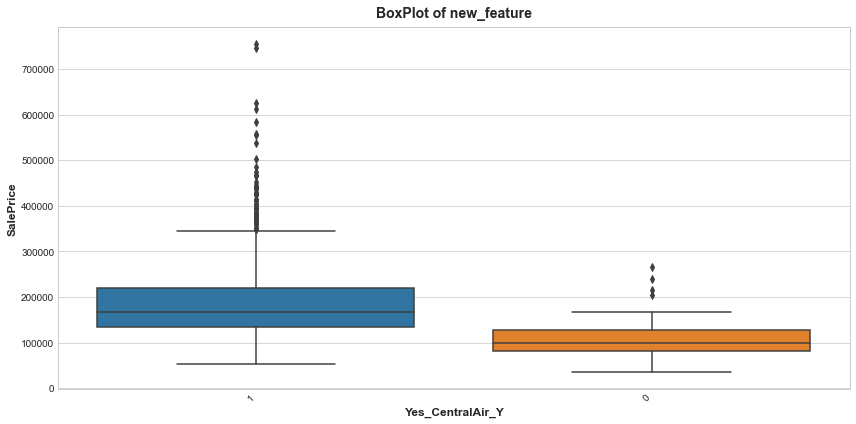



Yes_Electrical_SBrkr


mi_score  Corr_Score
base_Neighborhood     2.003888    0.738630
base_Exterior2nd      1.172542    0.392211
base_Exterior1st      1.116941    0.390862
base_BsmtFinType1     0.961786    0.459141
base_FireplaceQu      0.752668    0.542181
base_GarageFinish     0.752268    0.553059
base_BsmtQual         0.747080    0.681905
base_KitchenQual      0.676428    0.675721
base_GarageType       0.673624    0.499204
base_BsmtExposure     0.666649    0.386653
base_Foundation       0.637097    0.506328
base_HeatingQC        0.603568    0.442154
base_ExterQual        0.602146    0.690933
base_MasVnrType       0.558353    0.434537
base_SaleCondition    0.466175    0.368100
base_MSZoning         0.423127    0.327963
base_SaleType         0.403521    0.370523
Yes_Electrical_SBrkr  0.169822    0.241896

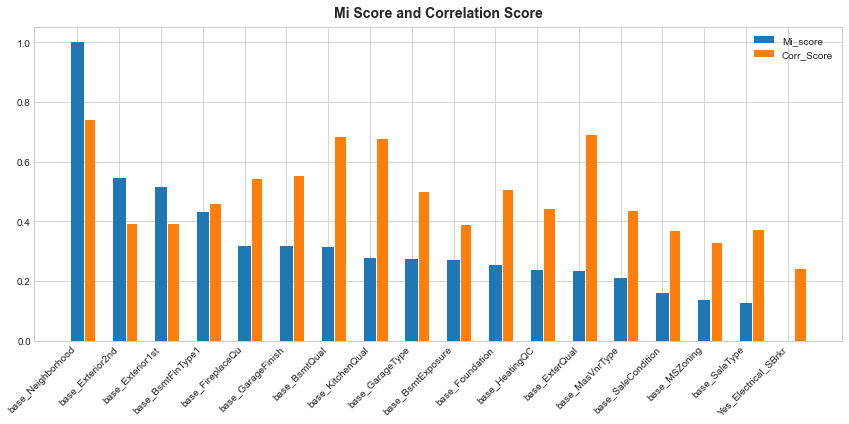

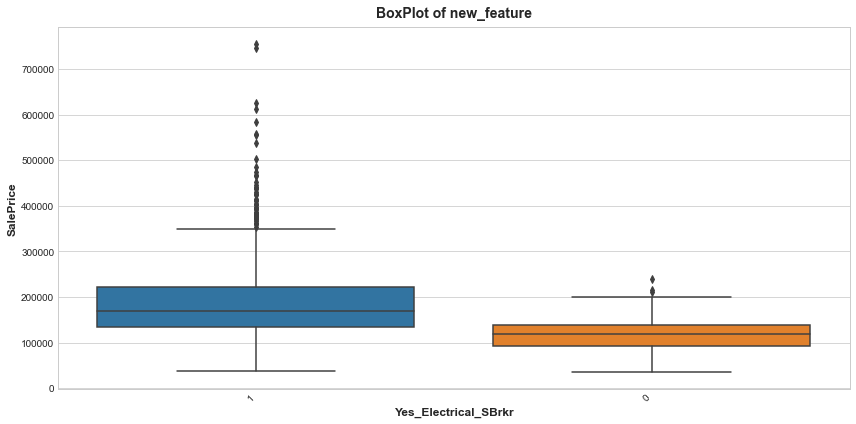



KitchenQ_Price_grade1


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
KitchenQ_Price_grade1  0.676428    0.675721
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523

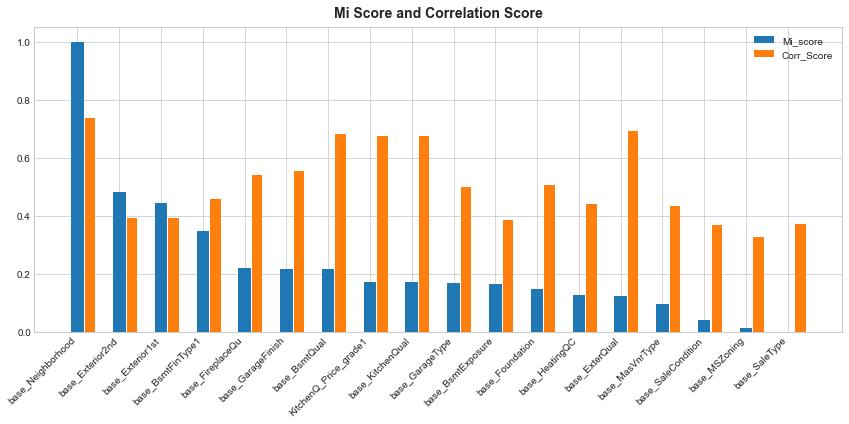

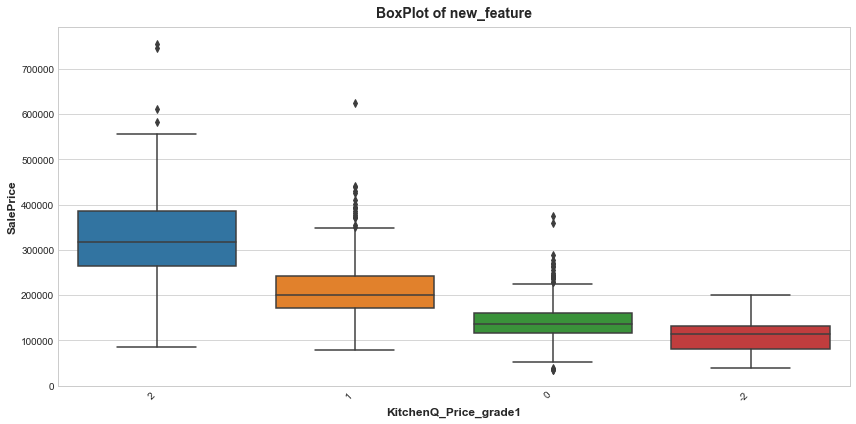



Yes_Functional_Typ


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
Yes_Functional_Typ  0.129753    0.116462

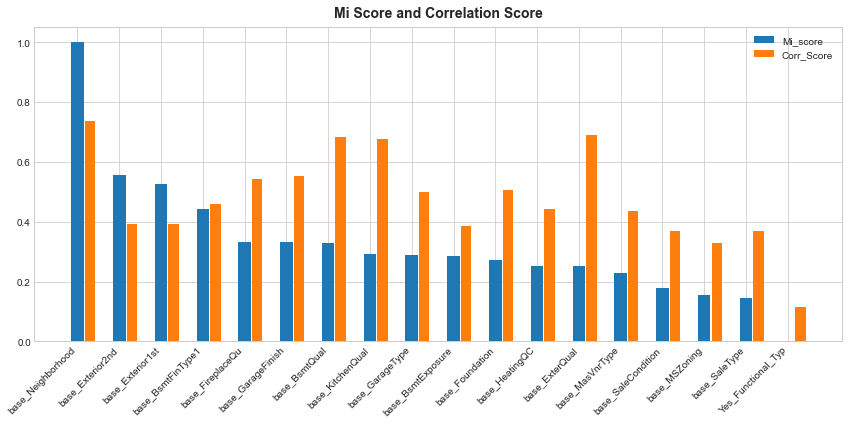

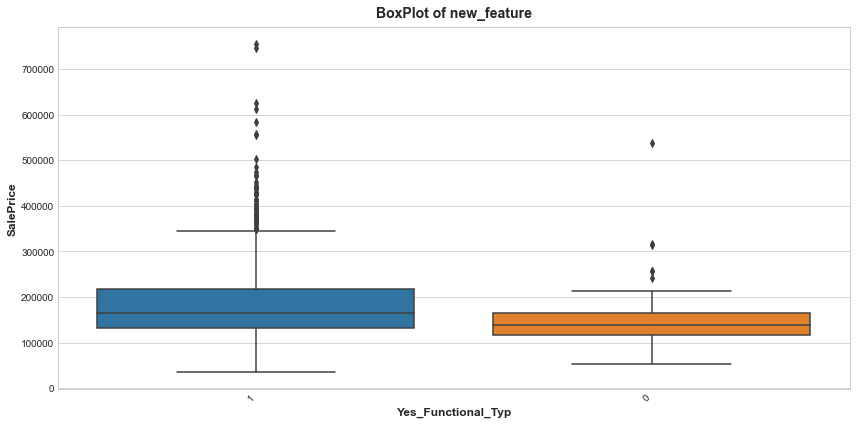



FireplaceQu_Price_grade1


mi_score  Corr_Score
base_Neighborhood         2.003888    0.738630
base_Exterior2nd          1.172542    0.392211
base_Exterior1st          1.116941    0.390862
base_BsmtFinType1         0.961786    0.459141
base_FireplaceQu          0.752668    0.542181
base_GarageFinish         0.752268    0.553059
base_BsmtQual             0.747080    0.681905
base_KitchenQual          0.676428    0.675721
base_GarageType           0.673624    0.499204
base_BsmtExposure         0.666649    0.386653
FireplaceQu_Price_grade1  0.653671    0.539732
base_Foundation           0.637097    0.506328
base_HeatingQC            0.603568    0.442154
base_ExterQual            0.602146    0.690933
base_MasVnrType           0.558353    0.434537
base_SaleCondition        0.466175    0.368100
base_MSZoning             0.423127    0.327963
base_SaleType             0.403521    0.370523

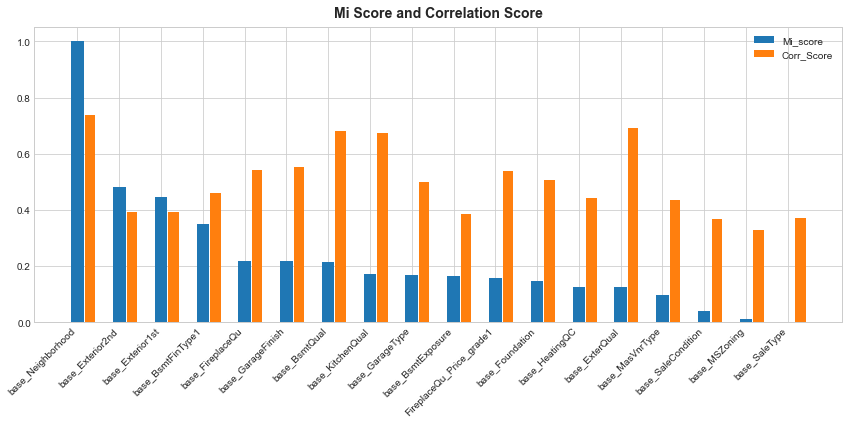

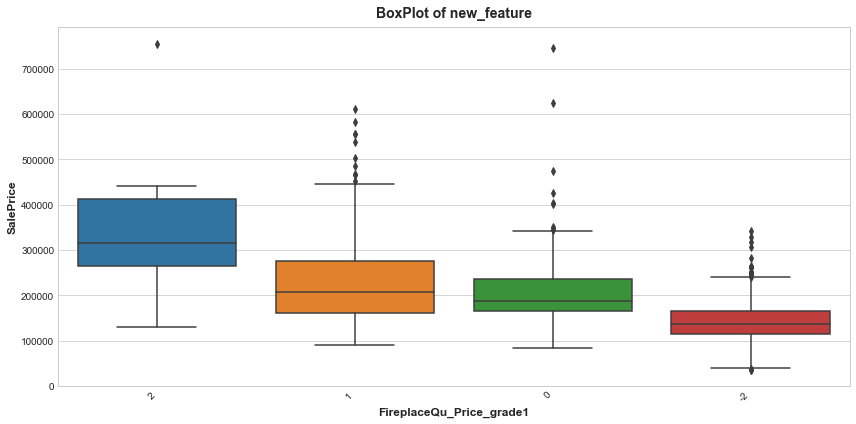



GarageType_InHome


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
GarageType_InHome   0.365497    0.460605

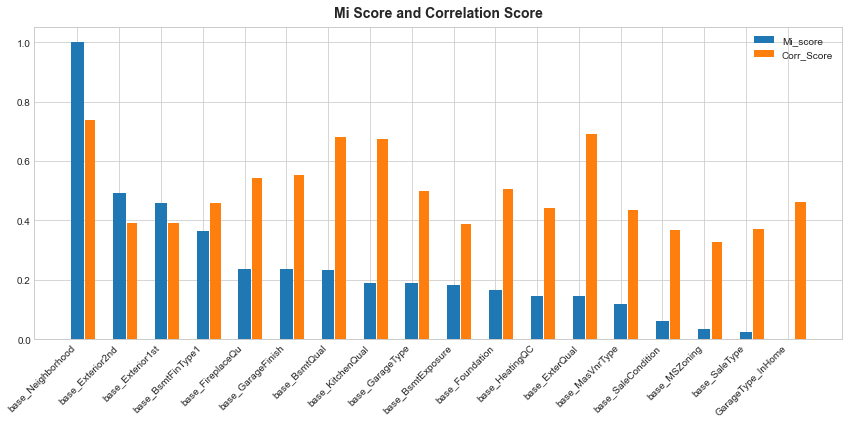

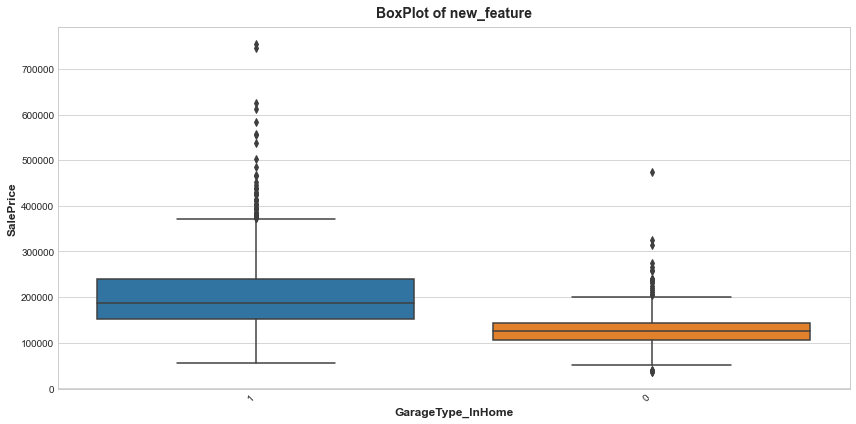



GarageFinish_ed


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
GarageFinish_ed     0.419497    0.513906
base_SaleType       0.403521    0.370523

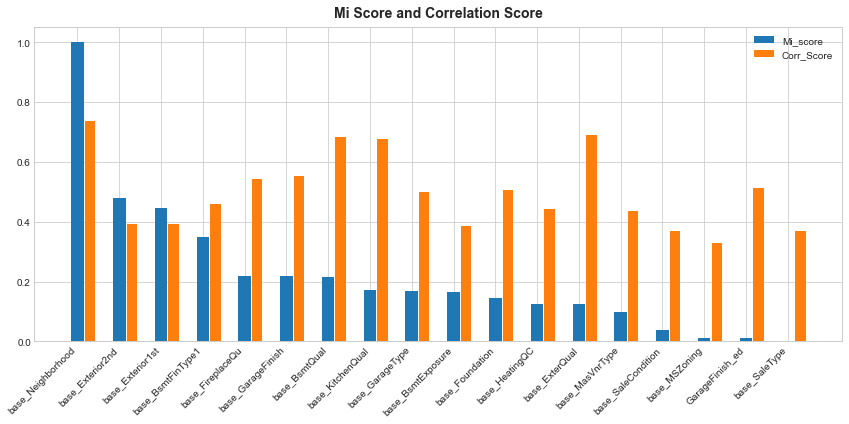

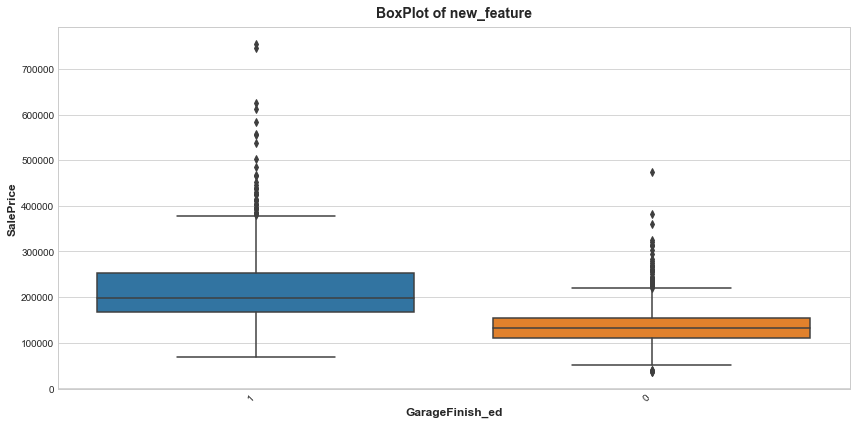



GarageFinish_Price_grade1


mi_score  Corr_Score
base_Neighborhood          2.003888    0.738630
base_Exterior2nd           1.172542    0.392211
base_Exterior1st           1.116941    0.390862
base_BsmtFinType1          0.961786    0.459141
base_FireplaceQu           0.752668    0.542181
base_GarageFinish          0.752268    0.553059
base_BsmtQual              0.747080    0.681905
base_KitchenQual           0.676428    0.675721
base_GarageType            0.673624    0.499204
base_BsmtExposure          0.666649    0.386653
base_Foundation            0.637097    0.506328
base_HeatingQC             0.603568    0.442154
base_ExterQual             0.602146    0.690933
base_MasVnrType            0.558353    0.434537
GarageFinish_Price_grade1  0.519307    0.525169
base_SaleCondition         0.466175    0.368100
base_MSZoning              0.423127    0.327963
base_SaleType              0.403521    0.370523

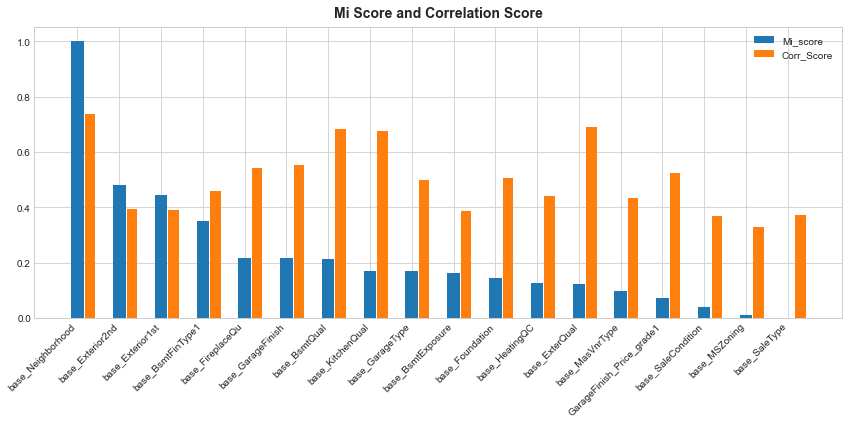

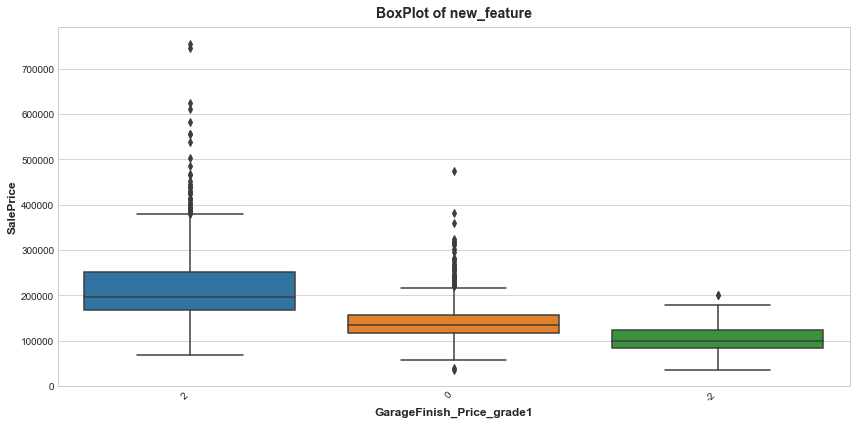



GarageQ_Avg&Above


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
GarageQ_Avg&Above   0.185065    0.279125

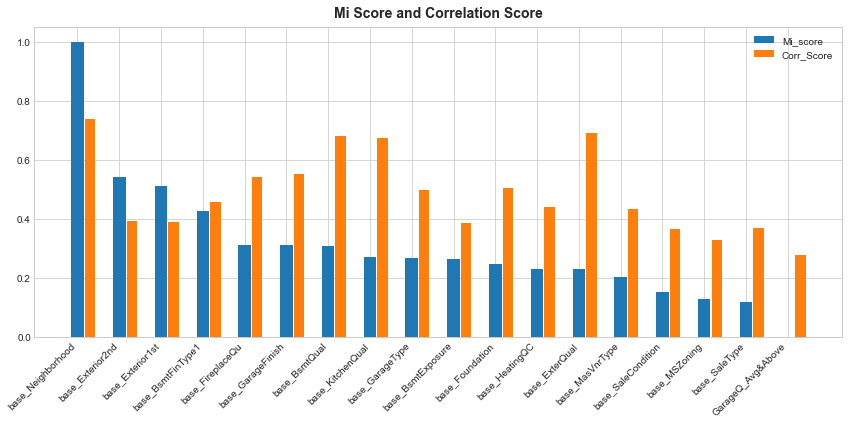

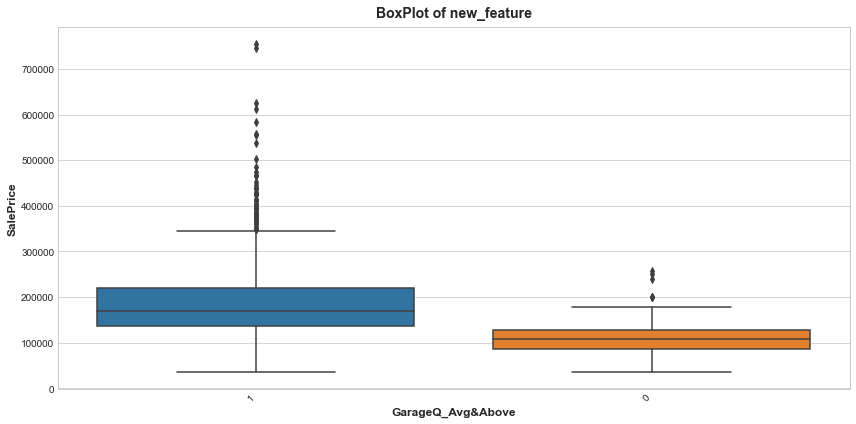



GarageC_Avg&Above


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
GarageC_Avg&Above   0.178294    0.282945

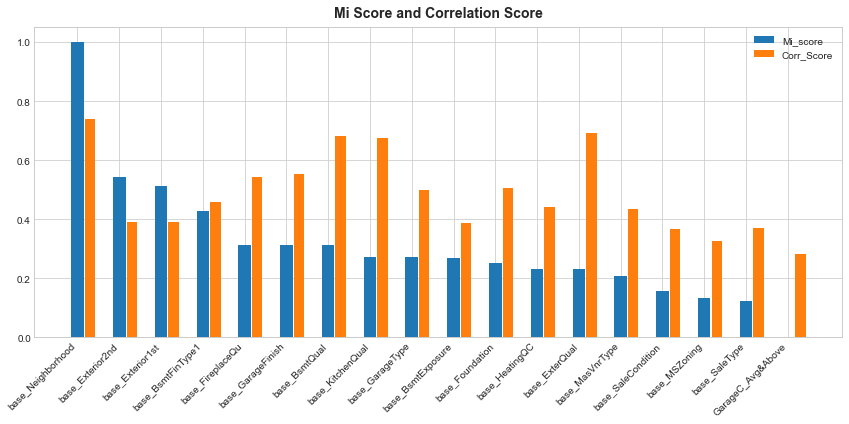

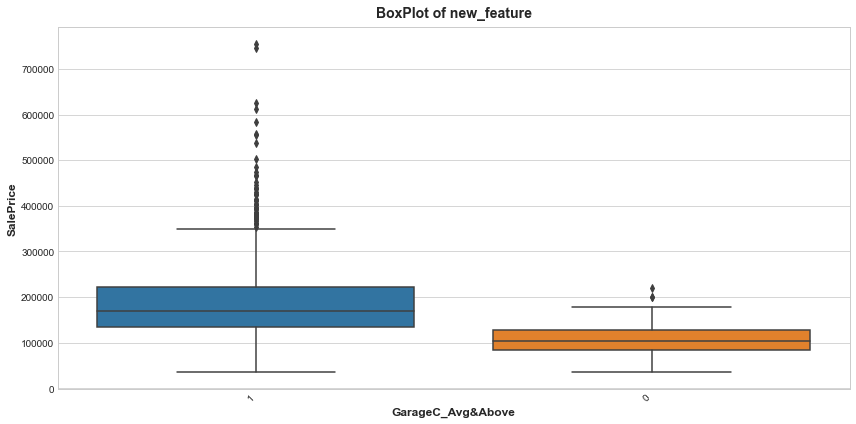



total_Garage_Q&C


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
total_Garage_Q&C    0.244655    0.296044

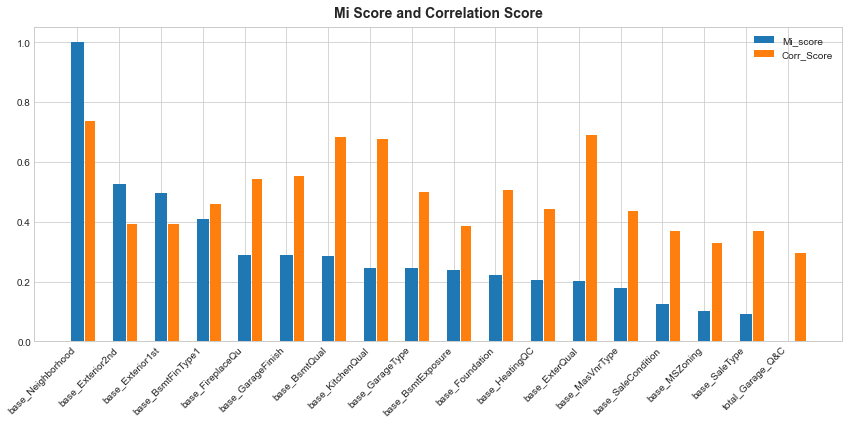

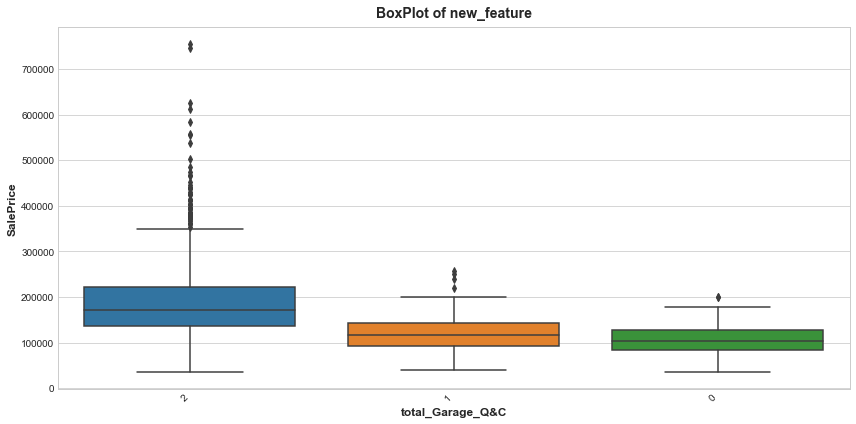



PavedDrive1


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
PavedDrive1         0.139791    0.212630

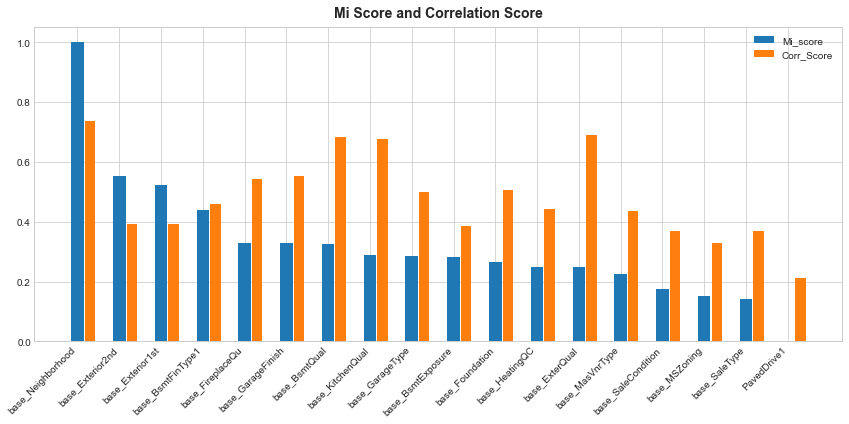

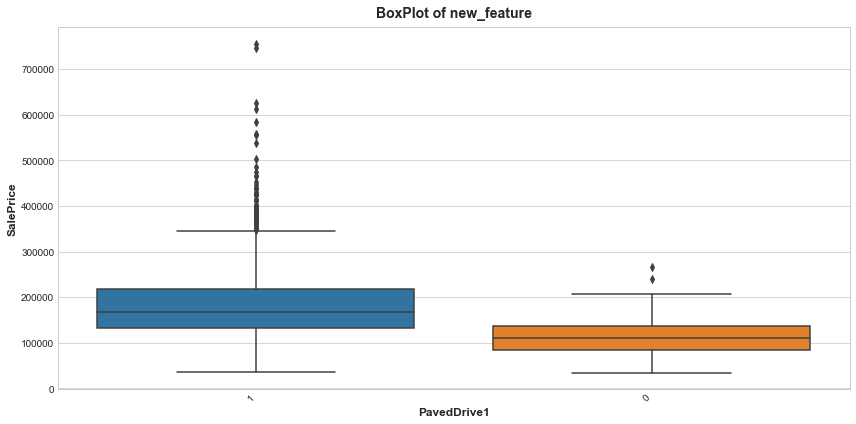



PoolQC1


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
PoolQC1             0.016822    0.100591

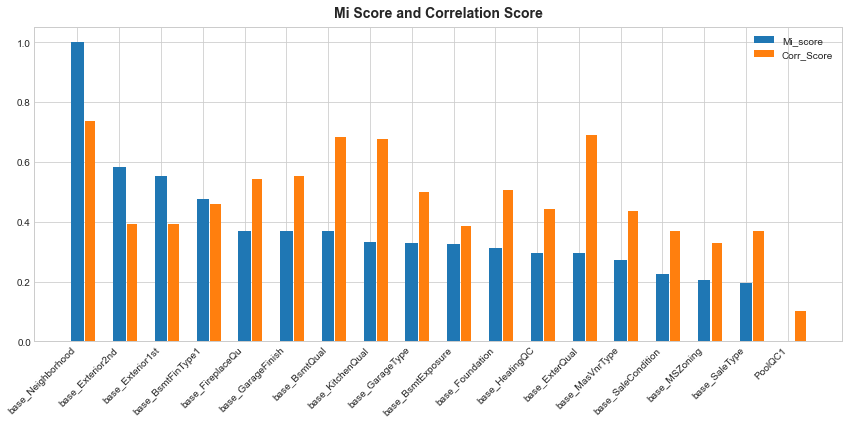

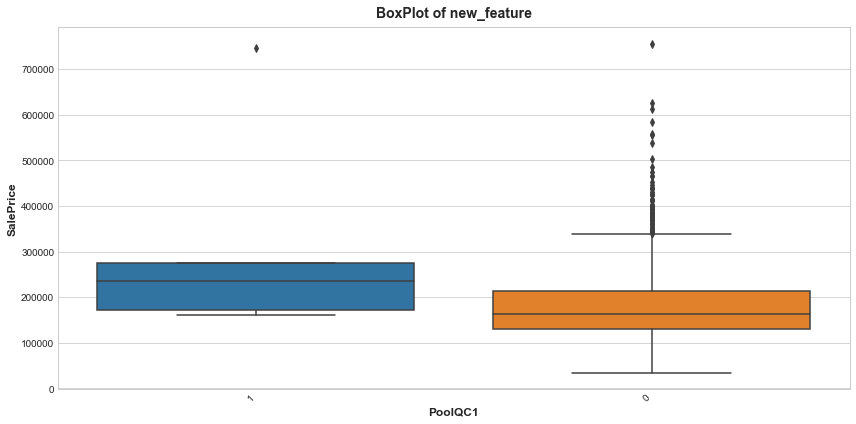



No_Fence_missing


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
No_Fence_missing    0.222691    0.172184

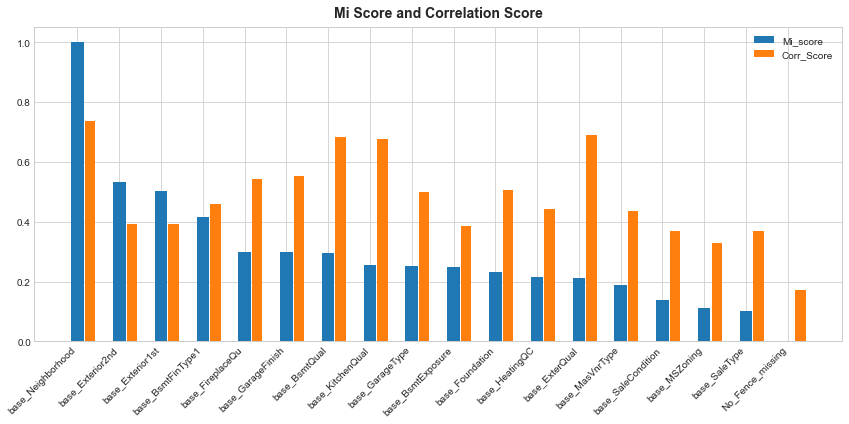

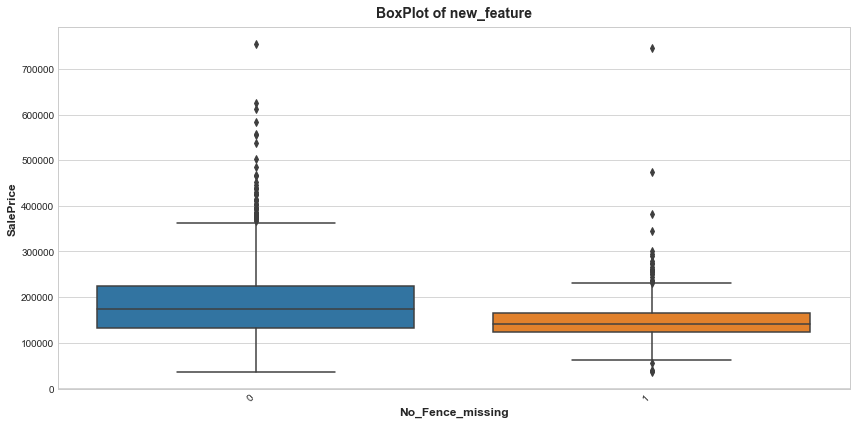



No_MiscFeature_missing


mi_score  Corr_Score
base_Neighborhood       2.003888    0.738630
base_Exterior2nd        1.172542    0.392211
base_Exterior1st        1.116941    0.390862
base_BsmtFinType1       0.961786    0.459141
base_FireplaceQu        0.752668    0.542181
base_GarageFinish       0.752268    0.553059
base_BsmtQual           0.747080    0.681905
base_KitchenQual        0.676428    0.675721
base_GarageType         0.673624    0.499204
base_BsmtExposure       0.666649    0.386653
base_Foundation         0.637097    0.506328
base_HeatingQC          0.603568    0.442154
base_ExterQual          0.602146    0.690933
base_MasVnrType         0.558353    0.434537
base_SaleCondition      0.466175    0.368100
base_MSZoning           0.423127    0.327963
base_SaleType           0.403521    0.370523
No_MiscFeature_missing  0.092661    0.072298

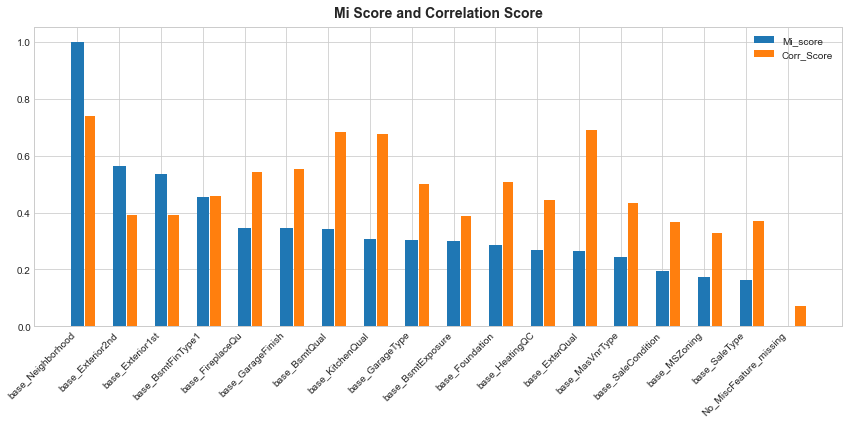



SaleType_Any_Warranty


mi_score  Corr_Score
base_Neighborhood      2.003888    0.738630
base_Exterior2nd       1.172542    0.392211
base_Exterior1st       1.116941    0.390862
base_BsmtFinType1      0.961786    0.459141
base_FireplaceQu       0.752668    0.542181
base_GarageFinish      0.752268    0.553059
base_BsmtQual          0.747080    0.681905
base_KitchenQual       0.676428    0.675721
base_GarageType        0.673624    0.499204
base_BsmtExposure      0.666649    0.386653
base_Foundation        0.637097    0.506328
base_HeatingQC         0.603568    0.442154
base_ExterQual         0.602146    0.690933
base_MasVnrType        0.558353    0.434537
base_SaleCondition     0.466175    0.368100
base_MSZoning          0.423127    0.327963
base_SaleType          0.403521    0.370523
SaleType_Any_Warranty  0.258181    0.241715

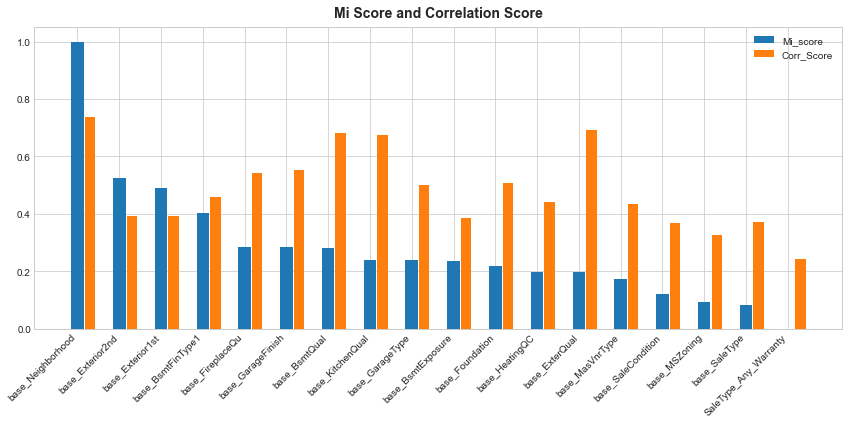

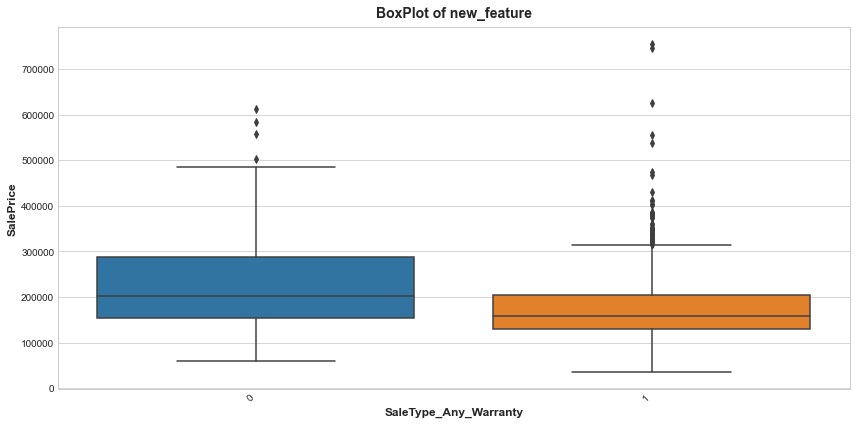



SaleType_New_House


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
SaleType_New_House  0.242856    0.357509

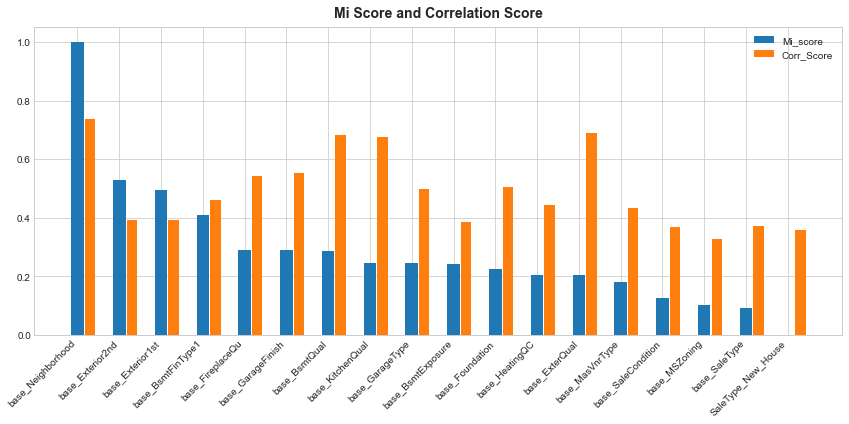

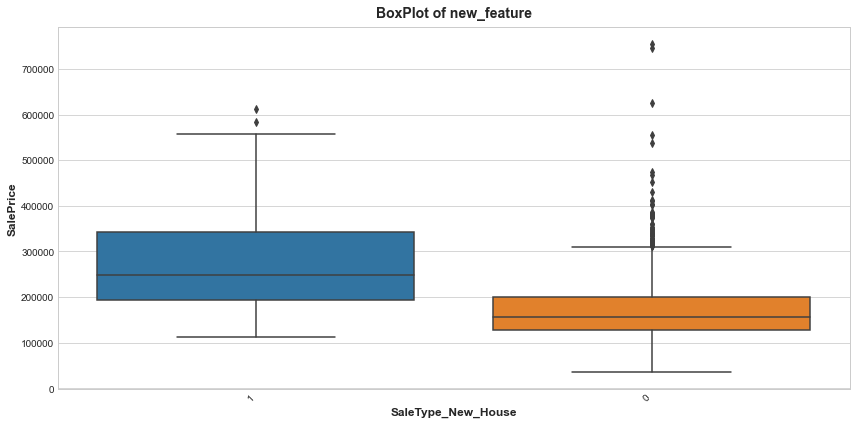



SaleCon_Normal


mi_score  Corr_Score
base_Neighborhood   2.003888    0.738630
base_Exterior2nd    1.172542    0.392211
base_Exterior1st    1.116941    0.390862
base_BsmtFinType1   0.961786    0.459141
base_FireplaceQu    0.752668    0.542181
base_GarageFinish   0.752268    0.553059
base_BsmtQual       0.747080    0.681905
base_KitchenQual    0.676428    0.675721
base_GarageType     0.673624    0.499204
base_BsmtExposure   0.666649    0.386653
base_Foundation     0.637097    0.506328
base_HeatingQC      0.603568    0.442154
base_ExterQual      0.602146    0.690933
base_MasVnrType     0.558353    0.434537
base_SaleCondition  0.466175    0.368100
base_MSZoning       0.423127    0.327963
base_SaleType       0.403521    0.370523
SaleCon_Normal      0.159815    0.135167



total_Utility_Count


mi_score  Corr_Score
base_Neighborhood    2.003888    0.738630
base_Exterior2nd     1.172542    0.392211
base_Exterior1st     1.116941    0.390862
base_BsmtFinType1    0.961786    0.459141
total_Utility_Count  0.922650    0.503936
base_FireplaceQu     0.752668    0.542181
base_GarageFinish    0.752268    0.553059
base_BsmtQual        0.747080    0.681905
base_KitchenQual     0.676428    0.675721
base_GarageType      0.673624    0.499204
base_BsmtExposure    0.666649    0.386653
base_Foundation      0.637097    0.506328
base_HeatingQC       0.603568    0.442154
base_ExterQual       0.602146    0.690933
base_MasVnrType      0.558353    0.434537
base_SaleCondition   0.466175    0.368100
base_MSZoning        0.423127    0.327963
base_SaleType        0.403521    0.370523

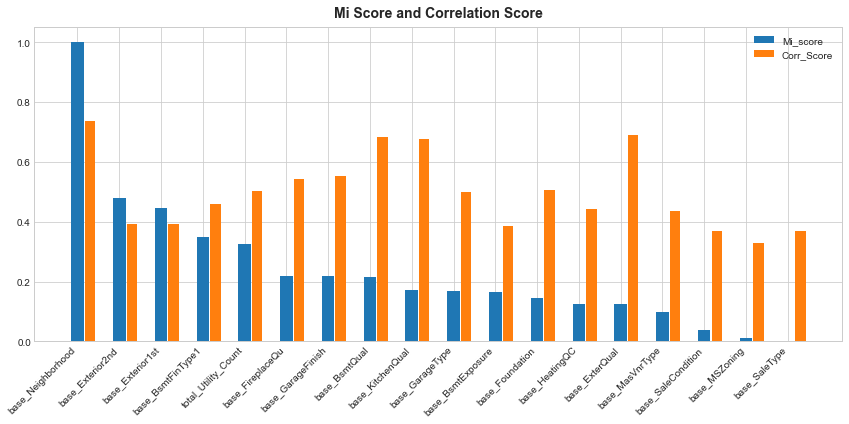

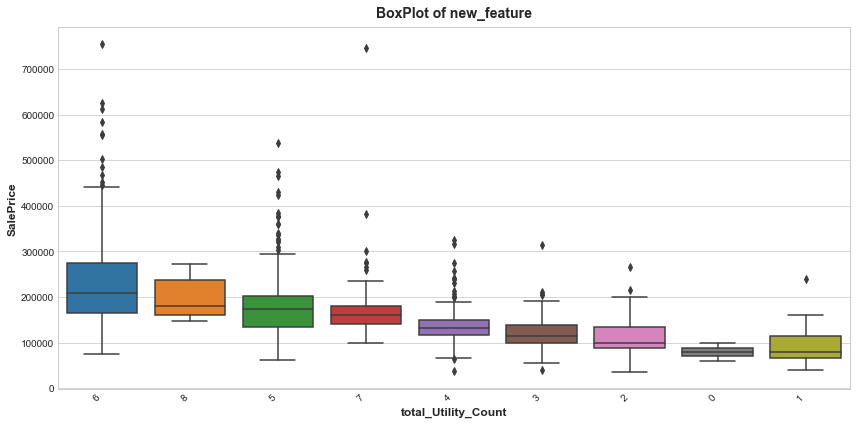

In [140]:
for col in created_features:    
    plot_corr_mi_median_one_feature(df=data,targets=train.SalePrice,cols=base_cat,target_col='SalePrice',active_col=col,fill_na='missing')


In [20]:
relevant =['Yes_BldgType_1Fam','HouseStyle_Story','HouseStyle','HStyle_Price_Grade','rare_Exterior1st','rare_Exterior2nd',
          'Mason_Exist','Mason_Exist','ExterQual_Price_grade','concat_Exterior','total_ExtQualCond','rare_Foundation','concat_BsmtQualCond',
          'BsmtExposure_Price_grade1','BsmtFin1_Price_grade1','HeatingQC_Price_grade1','KitchenQ_Price_grade1',
          'GarageType_InHome','GarageFinish_ed','SaleType_New_House','total_Utility_Count']

In [21]:
relevant.extend(base_cat)
relevant

['Yes_BldgType_1Fam',
 'HouseStyle_Story',
 'HouseStyle',
 'HStyle_Price_Grade',
 'rare_Exterior1st',
 'rare_Exterior2nd',
 'Mason_Exist',
 'Mason_Exist',
 'ExterQual_Price_grade',
 'concat_Exterior',
 'total_ExtQualCond',
 'rare_Foundation',
 'concat_BsmtQualCond',
 'BsmtExposure_Price_grade1',
 'BsmtFin1_Price_grade1',
 'HeatingQC_Price_grade1',
 'KitchenQ_Price_grade1',
 'GarageType_InHome',
 'GarageFinish_ed',
 'SaleType_New_House',
 'total_Utility_Count',
 'Neighborhood',
 'Exterior2nd',
 'Exterior1st',
 'BsmtFinType1',
 'FireplaceQu',
 'GarageFinish',
 'BsmtQual',
 'KitchenQual',
 'GarageType',
 'BsmtExposure',
 'Foundation',
 'HeatingQC',
 'ExterQual',
 'MasVnrType',
 'SaleCondition',
 'MSZoning',
 'SaleType']

In [22]:
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression

# try to return in terms of df or series
# check sorting of mi score
def feature_SelectKBest(X_train,y_train,score_func = mutual_info_regression, k=5):
    #from sklearn.feature_selection import SelectKBest,chi2, f_classif,SelectFpr
    
    bestfeatures = SelectKBest(score_func= score_func, k=k)
    fit = bestfeatures.fit(X_train,y_train)

    dfscores = pd.DataFrame(fit.scores_)

    dfcolumns = pd.DataFrame(X_train.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Score'] #naming the dataframe columns

    display(featureScores.nlargest(k,'Score')) #print 5best feature

In [15]:
def My_Ordinal_Encoding(df):
    """
        return dataframe with Ordinal encoded categorical columns
            params :
                            train = Pandas dataframe of Train
    """
    mx_LE = df.copy()
    for colname in mx_LE.select_dtypes(["category", "object"]):
        mx_LE[colname], _ = mx_LE[colname].factorize()
    return mx_LE

In [24]:
data_encoded = My_Ordinal_Encoding(df=data[relevant])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniqu

In [25]:
data_encoded

Yes_BldgType_1Fam  HouseStyle_Story  HouseStyle  HStyle_Price_Grade  \
0                     1                 0           0                   0   
1                     1                 1           1                   1   
2                     1                 0           0                   0   
3                     1                 0           0                   0   
4                     1                 0           0                   0   
...                 ...               ...         ...                 ...   
1455                  1                 0           0                   0   
1456                  1                 1           1                   1   
1457                  1                 0           0                   0   
1458                  1                 1           1                   1   
1459                  1                 1           1                   1   

      rare_Exterior1st  rare_Exterior2nd  Mason_Exist  Mason_Exist  \
0                    0                 0            1            1   
1                    1                 1            0            0   
2                    0                 0            1            1   
3                    2                 2            0            0   
4                    0                 0            1            1   
...                ...               ...          ...          ...   
1455                 0                 0            0            0   
1456                 7                 4            1            1   
1457                 6                 6            0            0   
1458                 1                 1            0            0   
1459                 3                 3            0            0   

      ExterQual_Price_grade  concat_Exterior  ...  KitchenQual  GarageType  \
0                         0                0  ...            0           0   
1                         1                1  ...            1           0   
2                         0                0  ...            0           0   
3                         1                1  ...            0           1   
4                         0                0  ...            0           0   
...                     ...              ...  ...          ...         ...   
1455                      1                1  ...            1           0   
1456                      1                1  ...            1           0   
1457                      0                5  ...            0           0   
1458                      1                1  ...            0           0   
1459                      0                0  ...            1           0   

      BsmtExposure  Foundation  HeatingQC  ExterQual  MasVnrType  \
0                0           0          0          0           0   
1                1           1          0          1           1   
2                2           0          0          0           0   
3                0           2          1          1           1   
4                3           0          0          0           0   
...            ...         ...        ...        ...         ...   
1455             0           0          0          1           1   
1456             0           1          2          1           2   
1457             0           5          0          2           1   
1458             2           1          1          1           1   
1459             0           1          1          0           1   

      SaleCondition  MSZoning  SaleType  
0                 0         0         0  
1                 0         0         0  
2                 0         0         0  
3                 1         0         0  
4                 0         0         0  
...             ...       ...       ...  
1455              0         0         0  
1456              0         0         0  
1457              0         0         0  
1458              0         0         0  
1459              0     

In [26]:
feature_SelectKBest(X_train=data_encoded,y_train=train.SalePrice,score_func = mutual_info_regression, k=30)

Features     Score
21            Neighborhood  0.508105
27                BsmtQual  0.334075
28             KitchenQual  0.329250
33               ExterQual  0.328132
16   KitchenQ_Price_grade1  0.323495
8    ExterQual_Price_grade  0.300648
9          concat_Exterior  0.287217
26            GarageFinish  0.258785
12     concat_BsmtQualCond  0.258239
18         GarageFinish_ed  0.228831
20     total_Utility_Count  0.219326
25             FireplaceQu  0.213968
29              GarageType  0.207780
10       total_ExtQualCond  0.201032
11         rare_Foundation  0.196602
31              Foundation  0.195329
17       GarageType_InHome  0.195243
15  HeatingQC_Price_grade1  0.168405
32               HeatingQC  0.167679
22             Exterior2nd  0.152526
14   BsmtFin1_Price_grade1  0.147481
24            BsmtFinType1  0.145985
5         rare_Exterior2nd  0.143554
4         rare_Exterior1st  0.139655
23             Exterior1st  0.125027
36                MSZoning  0.119148
34              MasVnrType  0.098461
37                SaleType  0.081670
2               HouseStyle  0.080057
1         HouseStyle_Story  0.075619

In [28]:
mut_drop = ['KitchenQ_Price_grade1','ExterQual_Price_grade','Foundation','HeatingQC','BsmtFinType1','Exterior1st']

In [29]:
mutual_k = data_encoded.drop(mut_drop,axis=1)

In [30]:
mutual_k

Yes_BldgType_1Fam  HouseStyle_Story  HouseStyle  HStyle_Price_Grade  \
0                     1                 0           0                   0   
1                     1                 1           1                   1   
2                     1                 0           0                   0   
3                     1                 0           0                   0   
4                     1                 0           0                   0   
...                 ...               ...         ...                 ...   
1455                  1                 0           0                   0   
1456                  1                 1           1                   1   
1457                  1                 0           0                   0   
1458                  1                 1           1                   1   
1459                  1                 1           1                   1   

      rare_Exterior1st  rare_Exterior2nd  Mason_Exist  Mason_Exist  \
0                    0                 0            1            1   
1                    1                 1            0            0   
2                    0                 0            1            1   
3                    2                 2            0            0   
4                    0                 0            1            1   
...                ...               ...          ...          ...   
1455                 0                 0            0            0   
1456                 7                 4            1            1   
1457                 6                 6            0            0   
1458                 1                 1            0            0   
1459                 3                 3            0            0   

      concat_Exterior  total_ExtQualCond  ...  GarageFinish  BsmtQual  \
0                   0                1.0  ...             0         0   
1                   1                0.0  ...             0         0   
2                   0                1.0  ...             0         0   
3                   1                0.0  ...             1         1   
4                   0                1.0  ...             0         0   
...               ...                ...  ...           ...       ...   
1455                1                0.0  ...             0         0   
1456                1                0.0  ...             1         0   
1457                5                2.0  ...             0         1   
1458                1                0.0  ...             1         1   
1459                0                1.0  ...             2         1   

      KitchenQual  GarageType  BsmtExposure  ExterQual  MasVnrType  \
0               0           0             0          0           0   
1               1           0             1          1           1   
2               0           0             2          0           0   
3               0           1             0          1           1   
4               0           0             3          0           0   
...           ...         ...           ...        ...         ...   
1455            1           0             0          1           1   
1456            1           0             0          1           2   
1457            0           0             0          2           1   
1458            0           0             2          1           1   
1459            1           0             0          0           1   

      SaleCondition  MSZoning  SaleType  
0                 0         0         0  
1                 0         0         0  
2                 0         0         0  
3                 1         0         0  
4                 0         0         0  
...             ...       ...       ...  
1455              0         0         0  
1456              0         0         0  
1457              0         0         0  
1458              0         0         0  
1459              0         0         0  

[1460 rows x 32 c

In [27]:
feature_SelectKBest(X_train=data_encoded,y_train=train.SalePrice,score_func = f_regression, k=30)

Features       Score
8       ExterQual_Price_grade  896.135932
10          total_ExtQualCond  532.694982
18            GarageFinish_ed  523.246497
11            rare_Foundation  428.744077
17          GarageType_InHome  392.623266
31                 Foundation  330.129861
32                  HeatingQC  326.323107
15     HeatingQC_Price_grade1  326.320471
20        total_Utility_Count  326.083973
14      BsmtFin1_Price_grade1  305.078832
25                FireplaceQu  282.461655
12        concat_BsmtQualCond  257.120174
24               BsmtFinType1  232.668539
6                 Mason_Exist  227.596252
7                 Mason_Exist  227.596252
19         SaleType_New_House  213.659813
9             concat_Exterior  149.146012
3          HStyle_Price_Grade  113.351210
33                  ExterQual  110.134366
29                 GarageType  101.876867
1            HouseStyle_Story   86.982593
13  BsmtExposure_Price_grade1   81.161336
2                  HouseStyle   53.825631
5            rare_Exterior2nd   47.885434
22                Exterior2nd   40.660476
21               Neighborhood   30.707622
35              SaleCondition   30.221556
0           Yes_BldgType_1Fam   28.089535
30               BsmtExposure   25.865542
23                Exterior1st   21.513454

In [32]:
def Prepare_Validation_Framework(df):    
    np.random.seed(2) # setting random seed

    n = len(df) # number of rows

    n_val = int(0.2 * n) # validation set is 20% of the data
    n_test = int(0.2 * n) # test set is 20% of the data
    n_train = n - (n_val + n_test) # training set  is 60% of the data

    idx = np.arange(n) # indexes
    np.random.shuffle(idx) # shuffling the data 

    df_shuffled = df.iloc[idx] #shuffled data frame

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    return df_train,df_val,df_test

In [33]:
df_train , df_val, df_test = Prepare_Validation_Framework(df=mutual_k)

In [34]:
def cross_val_class(X_train,y_train,classifier_list,classifier_name,scoring):
    """
    run quick cross validation
    params :
            :- classifier_list = array of models 
                    e.g >>> model = [AdaBoostClassifier(),RandomForestClassifier(n_estimators=50,max_leaf_nodes=25)]
            
            :- classifier_name = array (description of the model)
                    e.g >>> model_name= ['AdaBoostClassifier()','RandomForestClassifier','xg','et','lr','nb_m','dr']
                    
            
    """
    from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
    #kf=StratifiedShuffleSplit()
    mod=[]
    cv_score=[]
    for m in classifier_list:
        cv_score.append(np.sqrt(-1*cross_val_score(m,X_train,y_train,scoring=scoring,cv=5)))
    
    cross_val = pd.DataFrame(cv_score,index=classifier_name)
    return cross_val

In [35]:
from sklearn.metrics import SCORERS

In [ ]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [ ]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)